In [3]:
import os
import rosbag
import rospy
import tf
import numpy as np
import tf2_ros
import tf2_geometry_msgs


data_already_loaded = False

bag_dir_diff = '../../../dissertation_data/dissertation_data/diff_2'
bag_dir_omni = '../../../dissertation_data/dissertation_data/omni'

# List all .bag files in the directory
bag_files_diff = sorted([f for f in os.listdir(bag_dir_diff) if f.endswith('.bag')])
bag_files_omni = sorted([f for f in os.listdir(bag_dir_omni) if f.endswith('.bag')])

bag_file_diff_full = [bag_dir_diff + '/' + bag_file for bag_file in bag_files_diff]
bag_file_omni_full = [bag_dir_omni + '/' + bag_file for bag_file in bag_files_omni]

print('Diff:')
for bag_file in bag_file_diff_full:
    print(bag_file)

print('Omni:')
for bag_file in bag_file_omni_full:
    print(bag_file)

Diff:
../../../dissertation_data/dissertation_data/diff_2/a_first_perfect.bag
../../../dissertation_data/dissertation_data/diff_2/b_second_perfect.bag
../../../dissertation_data/dissertation_data/diff_2/c_third_scrach.bag
../../../dissertation_data/dissertation_data/diff_2/d_forth.bag
../../../dissertation_data/dissertation_data/diff_2/e_fifth.bag
Omni:
../../../dissertation_data/dissertation_data/omni/a_first_perfect.bag
../../../dissertation_data/dissertation_data/omni/b_second_perfect.bag
../../../dissertation_data/dissertation_data/omni/c_third_perfect.bag
../../../dissertation_data/dissertation_data/omni/d_forth_perfect.bag
../../../dissertation_data/dissertation_data/omni/e_fifth_little_scratch_end.bag


In [4]:
import pandas as pd
import ast

# Read the CSV file
df = pd.read_csv('time_values.csv')

# Function to convert string to list and handle errors
def convert_to_list(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError) as e:
        # print(f"Error converting {x}: {e}")
        return x  # Return original value if conversion fails

# Apply the conversion function to each column
for column in df.columns:
    df[column] = df[column].apply(convert_to_list)

# Print the DataFrame to inspect
print(df)

   Unnamed: 0          diff_go         diff_back         omni_go  \
0           0   [11.06, 95.89]  [129.65, 257.98]    [13.1, 77.7]   
1           1   [12.11, 96.97]  [130.81, 238.91]  [11.61, 73.26]   
2           2  [10.06, 110.98]   [137.2, 253.99]   [11.1, 86.32]   
3           3   [10.1, 100.91]  [145.83, 266.74]  [14.13, 91.38]   
4           4  [10.08, 101.45]  [129.66, 260.13]  [13.58, 81.28]   

          omni_back  
0   [103.4, 173.63]  
1   [109.6, 180.86]  
2  [130.18, 212.62]  
3  [146.93, 253.76]  
4  [109.05, 207.15]  


# Times that took to finish each experiment

In [13]:
diff_go_times = []
omni_go_times = []
diff_back_times = []
omni_back_times = []

for i in range(len(df)):
    diff_go_times.append(round(df['diff_go'][i][1] - df['diff_go'][i][0], 2))
    omni_go_times.append(round(df['omni_go'][i][1] - df['omni_go'][i][0], 2))
    diff_back_times.append(round(df['diff_back'][i][1] - df['diff_back'][i][0], 2))
    omni_back_times.append(round(df['omni_back'][i][1] - df['omni_back'][i][0], 2))

print('Diff Go Times:')
print(diff_go_times)
print('Omni Go Times:')
print(omni_go_times)
print('Diff Back Times:')
print(diff_back_times)
print('Omni Back Times:')
print(omni_back_times)

# min, max, mean, std

min_diff_go = round(min(diff_go_times), 2)
max_diff_go = round(max(diff_go_times), 2)
mean_diff_go = round(np.mean(diff_go_times), 2)
std_diff_go = round(np.std(diff_go_times), 2)

min_omni_go = round(min(omni_go_times), 2)
max_omni_go = round(max(omni_go_times), 2)
mean_omni_go = round(np.mean(omni_go_times), 2)
std_omni_go = round(np.std(omni_go_times), 2)

print(f"Diff Go Times - Min: {min_diff_go}, Max: {max_diff_go}, Mean: {mean_diff_go}, Std: {std_diff_go}")
print(f"Omni Go Times - Min: {min_omni_go}, Max: {max_omni_go}, Mean: {mean_omni_go}, Std: {std_omni_go}")

min_diff_back = round(min(diff_back_times), 2)
max_diff_back = round(max(diff_back_times), 2)
mean_diff_back = round(np.mean(diff_back_times), 2)
std_diff_back = round(np.std(diff_back_times), 2)

min_omni_back = round(min(omni_back_times), 2)
max_omni_back = round(max(omni_back_times), 2)
mean_omni_back = round(np.mean(omni_back_times), 2)
std_omni_back = round(np.std(omni_back_times), 2)

print(f"Diff Back Times - Min: {min_diff_back}, Max: {max_diff_back}, Mean: {mean_diff_back}, Std: {std_diff_back}")
print(f"Omni Back Times - Min: {min_omni_back}, Max: {max_omni_back}, Mean: {mean_omni_back}, Std: {std_omni_back}")

Diff Go Times:
[84.83, 84.86, 100.92, 90.81, 91.37]
Omni Go Times:
[64.6, 61.65, 75.22, 77.25, 67.7]
Diff Back Times:
[128.33, 108.1, 116.79, 120.91, 130.47]
Omni Back Times:
[70.23, 71.26, 82.44, 106.83, 98.1]
Diff Go Times - Min: 84.83, Max: 100.92, Mean: 90.56, Std: 5.89
Omni Go Times - Min: 61.65, Max: 77.25, Mean: 69.28, Std: 6.02
Diff Back Times - Min: 108.1, Max: 130.47, Mean: 120.92, Std: 8.09
Omni Back Times - Min: 70.23, Max: 106.83, Mean: 85.77, Std: 14.55


In [3]:
if not data_already_loaded:
    rospy.init_node('tf_buffer_node', anonymous=True)
    cache_time = rospy.Duration(172800) #Two days
    tf_buffer = tf2_ros.Buffer(cache_time=cache_time)

    go_times_omni = df.iloc[:, 1].values
    back_times_omni = df.iloc[:, 2].values

    go_times_diff = df.iloc[:, 3].values
    back_times_diff = df.iloc[:, 4].values

    # Omni bags
    for i, bag_file in enumerate(bag_file_omni_full):
        bag = rosbag.Bag(bag_file, 'r')
        first_time = None

        go_time_begin = go_times_omni[i][0] - 1 # 1 second before
        go_time_end = go_times_omni[i][1] + 1 # 1 second after
        back_time_begin = back_times_omni[i][0] - 1
        back_time_end = back_times_omni[i][1] + 1

        for topic, msg, t in bag.read_messages(topics=['/tf', '/tf_static', '/vrpn_client_node/L1/pose']):

            if topic == '/tf_static':
                for transform in msg.transforms:
                    tf_buffer.set_transform(transform, 'default_authority')
            
            if first_time is None:
                if topic == '/vrpn_client_node/L1/pose':
                    first_time = t.to_sec()
                else:
                    continue
            
            elapsed_time = t.to_sec() - first_time

            if ((elapsed_time >= go_time_begin) and (elapsed_time <= go_time_end)) or ((elapsed_time >= back_time_begin) and (elapsed_time <= back_time_end)):
                if topic == '/tf':
                    for transform in msg.transforms:
                        tf_buffer.set_transform(transform, 'default_authority')

        bag.close()

    # # Diff bags
    # for i, bag_file in enumerate(bag_file_diff_full):
    #     bag = rosbag.Bag(bag_file, 'r')
    #     first_time = None

    #     go_time_begin = go_times_diff[i][0] - 1
    #     go_time_end = go_times_diff[i][1] + 1
    #     back_time_begin = back_times_diff[i][0] - 1
    #     back_time_end = back_times_diff[i][1] + 1

    #     for topic, msg, t in bag.read_messages(topics=['/tf', '/tf_static', '/vrpn_client_node/L1/pose']):

    #         if topic == '/tf_static':
    #             for transform in msg.transforms:
    #                 tf_buffer.set_transform(transform, 'default_authority')
            
    #         if first_time is None:
    #             if topic == '/vrpn_client_node/L1/pose':
    #                 first_time = t.to_sec()
    #             else:
    #                 continue
            
    #         elapsed_time = t.to_sec() - first_time

    #         if ((elapsed_time >= go_time_begin) and (elapsed_time <= go_time_end)) or ((elapsed_time >= back_time_begin) and (elapsed_time <= back_time_end)):
    #             if topic == '/tf':
    #                 for transform in msg.transforms:
    #                     tf_buffer.set_transform(transform, 'default_authority')

    #     bag.close()

# 3m 28

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


/tmp/ipykernel_7393/491825911.py:26: UserWarning: translation should be of type Vector3
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_7393/491825911.py:26: UserWarning: rotation should be of type Quaternion
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_7393/491825911.py:39: UserWarning: translation should be of type Vector3
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_7393/491825911.py:39: UserWarning: rotation should be of type Quaternion
  tf_buffer.set_transform(transform, 'default_authority')


In [17]:
if not data_already_loaded:
    # Separate times to cut the data
    go_times = df.iloc[:, 3].values
    back_times = df.iloc[:, 4].values

    poses_omni_go = {}
    poses_omni_back = {}

    base_points_omni_go = {}
    base_points_omni_back = {}

    filtered_closest_points_omni_go = {}
    filtered_closest_points_omni_back = {}

    matched_base_points_omni_go = {}
    matched_base_points_omni_back = {}

    lidar_omni_go = {}
    lidar_omni_back = {}

    map_omni = {}

    local_map_omni_go = {}
    local_map_omni_back = {}

    local_path_omni_go = {}
    local_path_omni_back = {}

    smoothed_local_path_omni_go = {}
    smoothed_local_path_omni_back = {}

    for i, bag_file in enumerate(bag_file_omni_full):
        go_time_begin = go_times[i][0]
        go_time_end = go_times[i][1]
        back_time_begin = back_times[i][0]
        back_time_end = back_times[i][1]

        bag = rosbag.Bag(bag_file, 'r')
        poses_omni_go[i] = []
        poses_omni_back[i] = []

        base_points_omni_go[i] = []
        base_points_omni_back[i] = []

        filtered_closest_points_omni_go[i] = []
        filtered_closest_points_omni_back[i] = []

        matched_base_points_omni_go[i] = []
        matched_base_points_omni_back[i] = []

        lidar_omni_go[i] = []
        lidar_omni_back[i] = []

        map_omni[i] = None

        local_map_omni_go[i] = []
        local_map_omni_back[i] = []

        local_path_omni_go[i] = []
        local_path_omni_back[i] = []

        smoothed_local_path_omni_go[i] = []
        smoothed_local_path_omni_back[i] = []

        first_time = None

        for topic, msg, t in bag.read_messages(topics=['/vrpn_client_node/L1/pose', '/base_points', '/rplidar/scan', '/map', '/local_map', '/local_path', '/smoothed_local_path', '/closest_points', '/filtered_closest_points', '/matched_base_points']):
            
            if first_time is None:
                if topic == '/vrpn_client_node/L1/pose':
                    first_time = t.to_sec()
                else:
                    continue
            
            elapsed_time = t.to_sec() - first_time

            if ((elapsed_time >= go_time_begin) and (elapsed_time <= go_time_end)):
                # if topic == '/base_points':
                #     base_points_omni_go[i].append(msg)

                # if topic == '/filtered_closest_points':
                #     filtered_closest_points_omni_go[i].append(msg)
                
                # if topic == '/matched_base_points':
                #     matched_base_points_omni_go[i].append(msg)
                
                # if topic == '/rplidar/scan':
                #     lidar_omni_go[i].append(msg)
                
                # if topic == '/map':
                #     print('Map')
                #     map_omni[i] = msg
                
                # if topic == '/local_map':
                #     local_map_omni_go[i].append(msg)
                
                # if topic == '/local_path':
                #     local_path_omni_go[i].append(msg)
                
                # if topic == '/smoothed_local_path':
                #     smoothed_local_path_omni_go[i].append(msg)
                
                if topic == '/vrpn_client_node/L1/pose':
                    poses_omni_go[i].append(msg)

            if ((elapsed_time >= back_time_begin) and (elapsed_time <= back_time_end)):
                # if topic == '/base_points':
                #     base_points_omni_back[i].append(msg)
                
                # if topic == '/rplidar/scan':
                #     lidar_omni_back[i].append(msg)

                # if topic == '/filtered_closest_points':
                #     filtered_closest_points_omni_back[i].append(msg)
                
                # if topic == '/matched_base_points':
                #     matched_base_points_omni_back[i].append(msg)
                
                # # if topic == '/local_map':
                # #     local_map_omni_back[i].append(msg)
                
                # if topic == '/local_path':
                #     local_path_omni_back[i].append(msg)
                
                # if topic == '/smoothed_local_path':
                #     smoothed_local_path_omni_back[i].append(msg)
                
                if topic == '/vrpn_client_node/L1/pose':
                    poses_omni_back[i].append(msg)
        bag.close()

    del go_times, back_times
# 1m

In [18]:
if not data_already_loaded:
    # Separate times to cut the data
    go_times = df.iloc[:, 1].values
    back_times = df.iloc[:, 2].values

    poses_diff_go = {}
    poses_diff_back = {}

    base_points_diff_go = {}
    base_points_diff_back = {}

    filtered_closest_points_diff_go = {}
    filtered_closest_points_diff_back = {}

    matched_base_points_diff_go = {}
    matched_base_points_diff_back = {}

    lidar_diff_go = {}
    lidar_diff_back = {}

    map_diff = {}

    local_map_diff_go = {}
    local_map_diff_back = {}

    local_path_diff_go = {}
    local_path_diff_back = {}

    smoothed_local_path_diff_go = {}
    smoothed_local_path_diff_back = {}

    for i, bag_file in enumerate(bag_file_diff_full):
        go_time_begin = go_times[i][0]
        go_time_end = go_times[i][1]
        back_time_begin = back_times[i][0]
        back_time_end = back_times[i][1]

        bag = rosbag.Bag(bag_file, 'r')
        poses_diff_go[i] = []
        poses_diff_back[i] = []

        base_points_diff_go[i] = []
        base_points_diff_back[i] = []

        filtered_closest_points_diff_go[i] = []
        filtered_closest_points_diff_back[i] = []

        matched_base_points_diff_go[i] = []
        matched_base_points_diff_back[i] = []

        lidar_diff_go[i] = []
        lidar_diff_back[i] = []

        map_diff[i] = None

        local_map_diff_go[i] = []
        local_map_diff_back[i] = []

        local_path_diff_go[i] = []
        local_path_diff_back[i] = []

        smoothed_local_path_diff_go[i] = []
        smoothed_local_path_diff_back[i] = []

        first_time = None

        for topic, msg, t in bag.read_messages(topics=['/vrpn_client_node/L1/pose', '/base_points', '/rplidar/scan', '/map', '/local_map', '/local_path', '/smoothed_local_path', '/closest_points', '/filtered_closest_points', '/matched_base_points']):
            
            if first_time is None:
                if topic == '/vrpn_client_node/L1/pose':
                    first_time = t.to_sec()
                else:
                    continue
            
            elapsed_time = t.to_sec() - first_time

            if ((elapsed_time >= go_time_begin) and (elapsed_time <= go_time_end)):
                # if topic == '/base_points':
                #     base_points_diff_go[i].append(msg)

                # if topic == '/filtered_closest_points':
                #     filtered_closest_points_diff_go[i].append(msg)
                
                # if topic == '/matched_base_points':
                #     matched_base_points_diff_go[i].append(msg)
                
                # if topic == '/rplidar/scan':
                #     lidar_diff_go[i].append(msg)
                
                # if topic == '/map':
                #     map_diff[i] = msg
                
                # if topic == '/local_map':
                #     local_map_diff_go[i].append(msg)
                
                # if topic == '/local_path':
                #     local_path_diff_go[i].append(msg)
                
                # if topic == '/smoothed_local_path':
                #     smoothed_local_path_diff_go[i].append(msg)
                
                if topic == '/vrpn_client_node/L1/pose':
                    poses_diff_go[i].append(msg)

            if ((elapsed_time >= back_time_begin) and (elapsed_time <= back_time_end)):
                # if topic == '/base_points':
                #     base_points_diff_back[i].append(msg)
                
                # if topic == '/rplidar/scan':
                #     lidar_diff_back[i].append(msg)

                # if topic == '/filtered_closest_points':
                #     filtered_closest_points_diff_back[i].append(msg)
                
                # if topic == '/matched_base_points':
                #     matched_base_points_diff_back[i].append(msg)
                
                # # if topic == '/local_map':
                # #     local_map_diff_back[i].append(msg)
                
                # if topic == '/local_path':
                #     local_path_diff_back[i].append(msg)
                
                # if topic == '/smoothed_local_path':
                #     smoothed_local_path_diff_back[i].append(msg)
                
                if topic == '/vrpn_client_node/L1/pose':
                    poses_diff_back[i].append(msg)
        bag.close()

    del go_times, back_times

In [7]:
if not data_already_loaded:
    map_msg = None
    bag = rosbag.Bag(bag_file_omni_full[0], 'r')

    for topic, msg, t in bag.read_messages(topics=['/map']):
            
        if topic == '/map':
            print('Map')
            map_msg = msg

    bag.close()

Map
Map


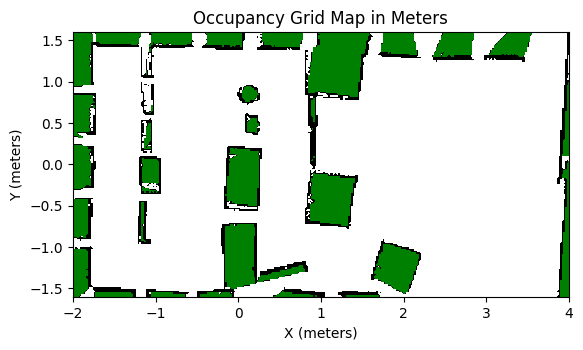

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Extract map metadata
resolution = map_msg.info.resolution  # meters per cell
origin_x = map_msg.info.origin.position.x  # map origin x (in meters)
origin_y = map_msg.info.origin.position.y  # map origin y (in meters)
width = map_msg.info.width
height = map_msg.info.height

# Convert the map data to a NumPy array
map_data = np.array(map_msg.data).reshape((height, width))

# Create a custom color map: white for free space, black for obstacles, green for unknown
cmap = ListedColormap(['white', 'black', 'green'])

# Replace values to correspond to the desired colors:
# - 0: free space (white), 100: obstacle (black), -1: unknown (green)
map_data_visual = np.copy(map_data)
map_data_visual[map_data == -1] = 2  # Set unknown cells to 2 (green)
map_data_visual[map_data == 0] = 0   # Set free space cells to 0 (white)
map_data_visual[map_data > 0] = 1    # Set occupied cells to 1 (black)

# Create the figure with correct scaling in meters
fig, ax = plt.subplots()
extent = [origin_x, origin_x + width * resolution, origin_y, origin_y + height * resolution]
cax = ax.imshow(map_data_visual, cmap=cmap, origin='lower', extent=extent)

x_limits = [-2, 4]  # Set your desired x limits (start and end in meters)
y_limits = [-1.6, 1.6]  

# Set labels and title
ax.set_title('Occupancy Grid Map in Meters')
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

plt.show()

# Coletar dados de distância percorrida

## Corrigindo ponto central no diferencial

In [26]:
import tf
from geometry_msgs.msg import PoseStamped

new_diff_go_poses = {}
new_diff_back_poses = {}
diff_go_yaw = {}
diff_back_yaw = {}

for i in range(len(poses_diff_go)):
    new_diff_go_poses[i] = []
    yaw_ = []
    
    for pose in poses_diff_go[i]:
        x = pose.pose.position.x  # Corrected attribute access
        y = pose.pose.position.y  # Corrected attribute access

        orientation_q = pose.pose.orientation
        orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
        _, _, yaw = tf.transformations.euler_from_quaternion(orientation_list)
        yaw_.append(yaw)
        
        # Calculate new position 6.5cm in front of the current position
        new_x = x - 0.065 * np.cos(yaw)
        new_y = y - 0.065 * np.sin(yaw)
        
        new_pose = PoseStamped()
        new_pose.header = pose.header
        new_pose.pose.position.x = new_x
        new_pose.pose.position.y = new_y
        new_pose.pose.position.z = pose.pose.position.z
        new_pose.pose.orientation = pose.pose.orientation

        new_diff_go_poses[i].append(new_pose)
    yaw_ = np.array(yaw_)
    diff_go_yaw[i] = yaw_

for i in range(len(poses_diff_back)):
    new_diff_back_poses[i] = []
    yaw_ = []
    
    for pose in poses_diff_back[i]:
        x = pose.pose.position.x
        y = pose.pose.position.y

        orientation_q = pose.pose.orientation
        orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
        _, _, yaw = tf.transformations.euler_from_quaternion(orientation_list)

        yaw_.append(yaw)
        
        # Calculate new position 6.5cm in front of the current position
        new_x = x - 0.065 * np.cos(yaw)
        new_y = y - 0.065 * np.sin(yaw)
        
        new_pose = PoseStamped()
        new_pose.header = pose.header
        new_pose.pose.position.x = new_x
        new_pose.pose.position.y = new_y
        new_pose.pose.position.z = pose.pose.position.z
        new_pose.pose.orientation = pose.pose.orientation

        new_diff_back_poses[i].append(new_pose)
    yaw_ = np.array(yaw_)
    diff_back_yaw[i] = yaw_

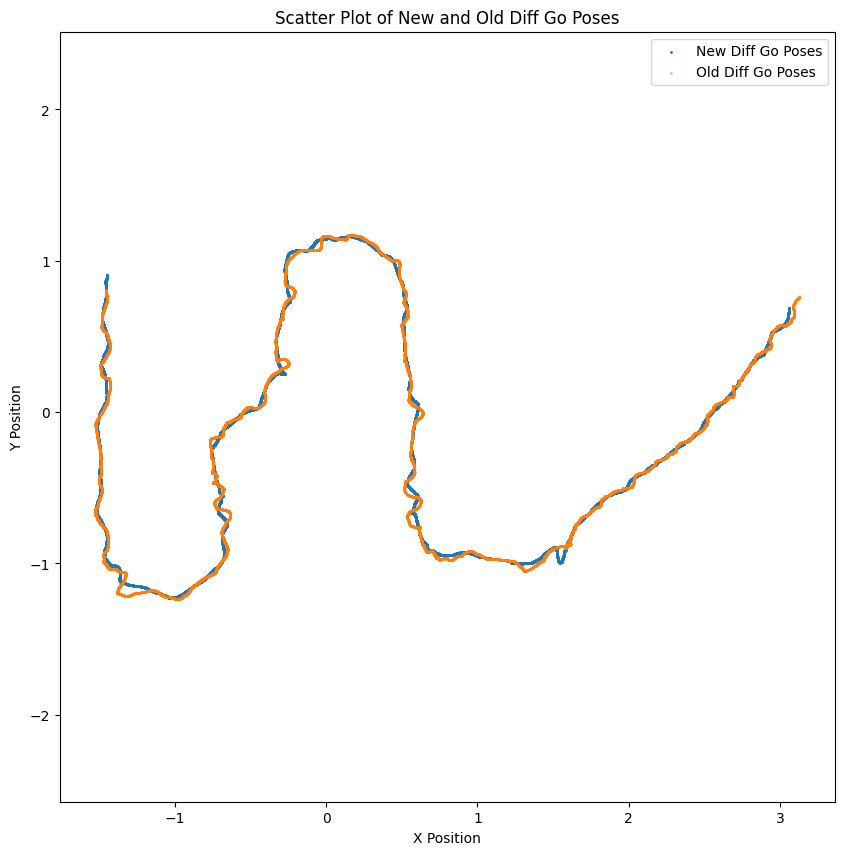

In [63]:
import matplotlib.pyplot as plt

# Extract positions from new_diff_go_poses for the first set of poses
new_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_diff_go_poses[0]])

# Extract positions from poses_diff_go for the first set of poses
old_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in poses_diff_go[0]])

# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(new_positions[:, 0], new_positions[:, 1], label='New Diff Go Poses', s=1)
plt.scatter(old_positions[:, 0], old_positions[:, 1], label='Old Diff Go Poses', s=1, alpha=0.5)

# Set plot labels and title
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.title('Scatter Plot of New and Old Diff Go Poses')
plt.legend()
plt.show()

In [60]:
from PIL import Image

# Function to get the dominant color in an image
def get_dominant_color(image_path):
    image = Image.open(image_path)
    image = image.resize((1, 1))  # Resize the image to 1x1 to get the dominant color
    dominant_color = image.getpixel((0, 0))  # Get the RGB value of the pixel
    return '#{:02x}{:02x}{:02x}'.format(*dominant_color)

# Path to the images
image1_path = 'light_gray.png' 
image2_path = 'dark_green.png'

# Get the dominant colors
color1_hex = get_dominant_color(image1_path)
color2_hex = get_dominant_color(image2_path)

# Print the results
print(f"Light gray color (free space): {color1_hex}")
print(f"Dark gray color (unknown space): {color2_hex}")

Light gray color (free space): #808080
Dark gray color (unknown space): #384443


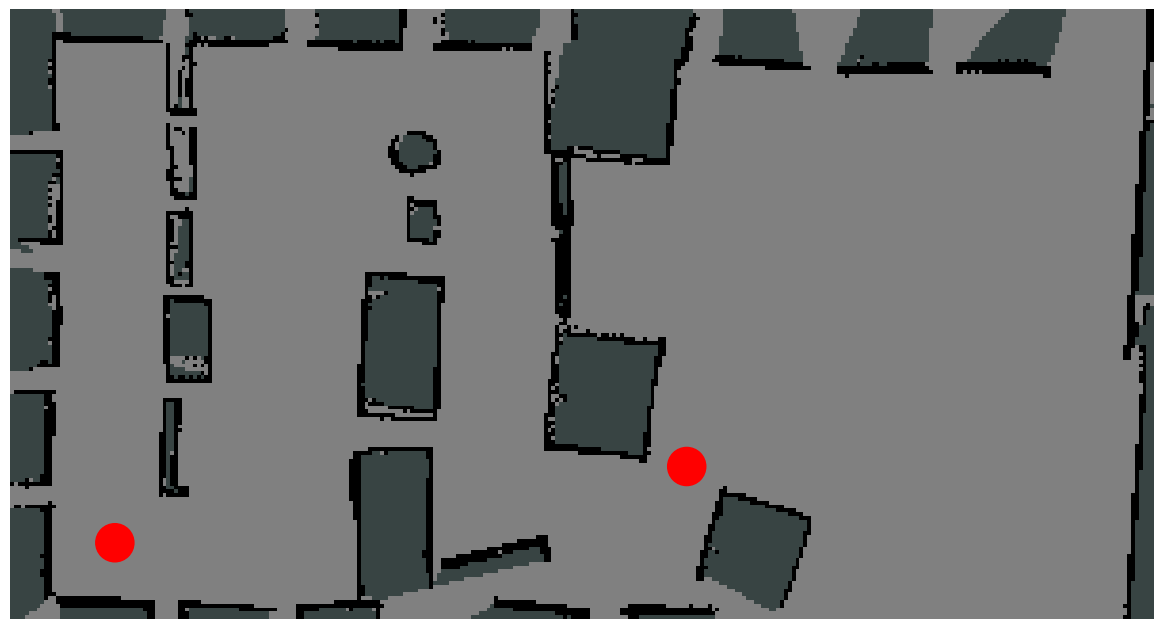

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Map metadata
resolution = map_msg.info.resolution  # meters per cell
origin_x = map_msg.info.origin.position.x  # map origin x (in meters)
origin_y = map_msg.info.origin.position.y  # map origin y (in meters)
width = map_msg.info.width
height = map_msg.info.height

# Convert the map data to a NumPy array
map_data = np.array(map_msg.data).reshape((height, width))
cmap = ListedColormap([color1_hex, '#000000', color2_hex]) 
# Create a custom color map: white for free space, black for obstacles, green for unknown
# cmap = ListedColormap(['white', 'black', 'green'])

# Replace values to correspond to the desired colors:
# - 0: free space (white), 100: obstacle (black), -1: unknown (green)
map_data_visual = np.copy(map_data)
map_data_visual[map_data == -1] = 2  # Set unknown cells to 2 (green)
map_data_visual[map_data == 0] = 0   # Set free space cells to 0 (white)
map_data_visual[map_data > 0] = 1    # Set occupied cells to 1 (black)

# Extract positions from new_diff_go_poses and poses_diff_go for path plotting
new_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_diff_go_poses[0]])
x_range = x_limits[1] - x_limits[0]
y_range = y_limits[1] - y_limits[0]
aspect_ratio = x_range / y_range
# Create the figure with correct scaling in meters
# Set the figure size based on the aspect ratio
fig_width = 12  # You can adjust the width as desired
fig_height = fig_width / aspect_ratio

# Create the figure with the correct aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
extent = [origin_x, origin_x + width * resolution, origin_y, origin_y + height * resolution]
ax.imshow(map_data_visual, cmap=cmap, origin='lower', extent=extent)

# Plot the paths on top of the map
# ax.scatter(new_positions[:, 0], new_positions[:, 1], label='New Diff Go Poses', s=0.1, color='blue')

# Set your desired x and y limits
x_limits = [-2, 4]  # Set your desired x limits (start and end in meters)
y_limits = [-1.6, 1.6]
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

# Set labels and title
# ax.set_title('Occupancy Grid Map with Path Overlay')
# ax.set_xlabel('X (meters)')
# ax.set_ylabel('Y (meters)')
# ax.legend()
# Draw a circle
circle_1 = plt.Circle((-1.45, -1.2), 0.1, color='red', fill=True)
circle_2 = plt.Circle((1.55, -0.8), 0.1, color='red', fill=True)

cut_position_1 = np.array([-1.45, -1.2])
cut_position_2 = np.array([1.55, -0.8])

ax.add_patch(circle_1)
ax.add_patch(circle_2)

plt.axis('off')

plt.tight_layout()
fig.savefig('map_with_circles.png', dpi=300)
plt.show()

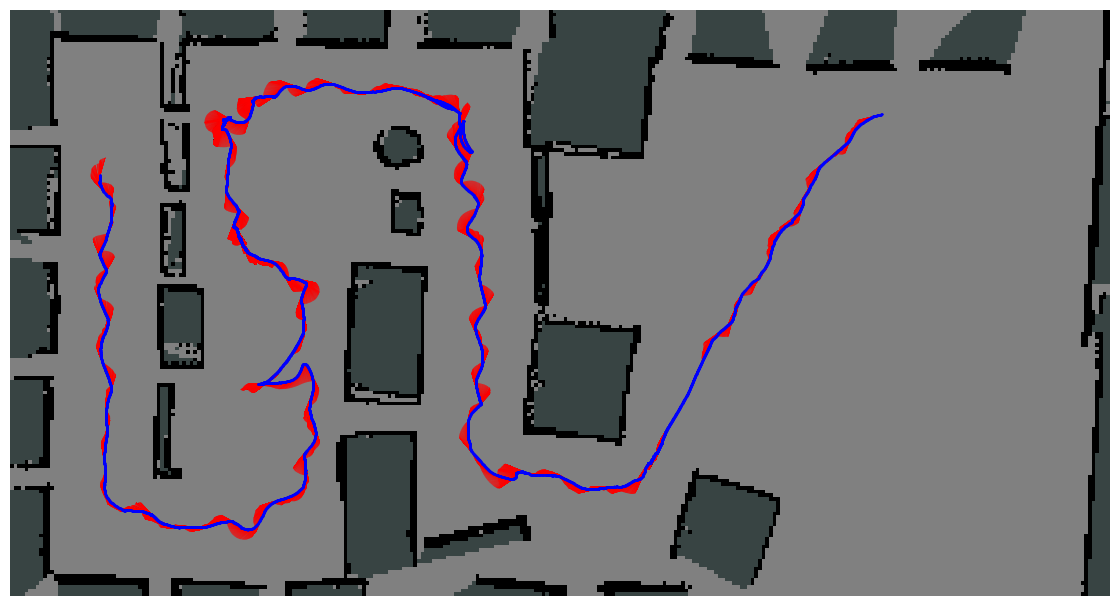

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Map metadata
resolution = map_msg.info.resolution  # meters per cell
origin_x = map_msg.info.origin.position.x  # map origin x (in meters)
origin_y = map_msg.info.origin.position.y  # map origin y (in meters)
width = map_msg.info.width
height = map_msg.info.height

# Convert the map data to a NumPy array
map_data = np.array(map_msg.data).reshape((height, width))

# Create a custom color map: white for free space, black for obstacles, green for unknown
cmap = ListedColormap([color1_hex, '#000000', color2_hex]) 

# Replace values to correspond to the desired colors:
# - 0: free space (white), 100: obstacle (black), -1: unknown (green)
map_data_visual = np.copy(map_data)
map_data_visual[map_data == -1] = 2  # Set unknown cells to 2 (green)
map_data_visual[map_data == 0] = 0   # Set free space cells to 0 (white)
map_data_visual[map_data > 0] = 1    # Set occupied cells to 1 (black)

# Extract positions from new_diff_go_poses and poses_diff_go for path plotting
new_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_diff_back_poses[0]])
orientation = diff_back_yaw[0]

line_length = 0.1

# Calculate the aspect ratio based on x and y limits
x_limits = [-2, 4]  # Set your desired x limits (start and end in meters)
y_limits = [-1.6, 1.6]
x_range = x_limits[1] - x_limits[0]
y_range = y_limits[1] - y_limits[0]
aspect_ratio = x_range / y_range

# Set the figure size based on the aspect ratio
fig_width = 12  # You can adjust the width as desired
fig_height = fig_width / aspect_ratio

# Create the figure with the correct aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create the figure with correct scaling in meters
extent = [origin_x, origin_x + width * resolution, origin_y, origin_y + height * resolution]
ax.imshow(map_data_visual, cmap=cmap, origin='lower', extent=extent)

# Plot the paths on top of the map with smaller points
ax.scatter(new_positions[:, 0], new_positions[:, 1], label='New Diff Go Poses', s=0.2, color='blue', zorder=3)

# Plot the orientation lines with a thinner width
for (position, orientation) in zip(new_positions, orientation):
    x_start, y_start = position 
    x_end = x_start + line_length * np.cos(orientation)  
    y_end = y_start + line_length * np.sin(orientation) 

    # Plot the line for each robot position and orientation with thinner linewidth
    ax.plot([x_start, x_end], [y_start, y_end], color='red', zorder=2, linewidth=0.2)

# Set your x and y limits
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
# # Set labels and title
# ax.set_title('Occupancy Grid Map with Path Overlay')
# ax.set_xlabel('X (meters)')
# ax.set_ylabel('Y (meters)')
# ax.legend()
plt.tight_layout()
plt.axis('off')


fig.savefig('diff_path.png', dpi=300)
plt.show()


In [36]:
import tf
from geometry_msgs.msg import PoseStamped

new_omni_go_poses = {}
new_omni_back_poses = {}
omni_go_yaw = {}
omni_back_yaw = {}

for i in range(len(poses_omni_go)):
    new_omni_go_poses[i] = []
    yaw_ = []
    
    for pose in poses_omni_go[i]:
        x = pose.pose.position.x
        y = pose.pose.position.y

        orientation_q = pose.pose.orientation
        orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
        _, _, yaw = tf.transformations.euler_from_quaternion(orientation_list)
        yaw_.append(yaw)
        
        # Calculate new position 8cm in front of the current position
        new_x = x - 0.08 * np.cos(yaw)
        new_y = y - 0.08 * np.sin(yaw)
        
        new_pose = PoseStamped()
        new_pose.header = pose.header
        new_pose.pose.position.x = new_x
        new_pose.pose.position.y = new_y
        new_pose.pose.position.z = pose.pose.position.z
        new_pose.pose.orientation = pose.pose.orientation

        new_omni_go_poses[i].append(new_pose)
    yaw_ = np.array(yaw_)
    omni_go_yaw[i] = yaw_

for i in range(len(poses_omni_back)):
    new_omni_back_poses[i] = []
    yaw_ = []
    
    for pose in poses_omni_back[i]:
        x = pose.pose.position.x
        y = pose.pose.position.y

        orientation_q = pose.pose.orientation
        orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
        _, _, yaw = tf.transformations.euler_from_quaternion(orientation_list)
        yaw_.append(yaw)
        
        # Calculate new position 8cm in front of the current position
        new_x = x - 0.08 * np.cos(yaw)
        new_y = y - 0.08 * np.sin(yaw)
        
        new_pose = PoseStamped()
        new_pose.header = pose.header
        new_pose.pose.position.x = new_x
        new_pose.pose.position.y = new_y
        new_pose.pose.position.z = pose.pose.position.z
        new_pose.pose.orientation = pose.pose.orientation

        new_omni_back_poses[i].append(new_pose)
    yaw_ = np.array(yaw_)
    omni_back_yaw[i] = yaw_

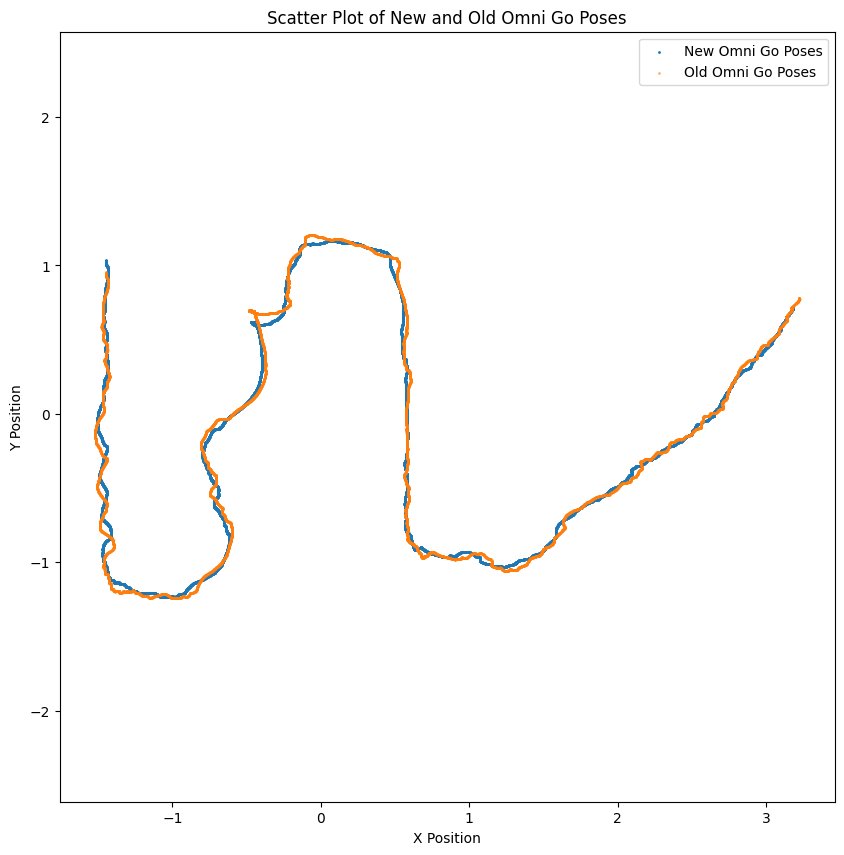

In [69]:
new_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_omni_go_poses[0]])

old_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in poses_omni_go[0]])

plt.figure(figsize=(10, 10))

plt.scatter(new_positions[:, 0], new_positions[:, 1], label='New Omni Go Poses', s=1)
plt.scatter(old_positions[:, 0], old_positions[:, 1], label='Old Omni Go Poses', s=1, alpha=0.5)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.title('Scatter Plot of New and Old Omni Go Poses')
plt.legend()
plt.show()

# Cut data on between cut position 1 and 2

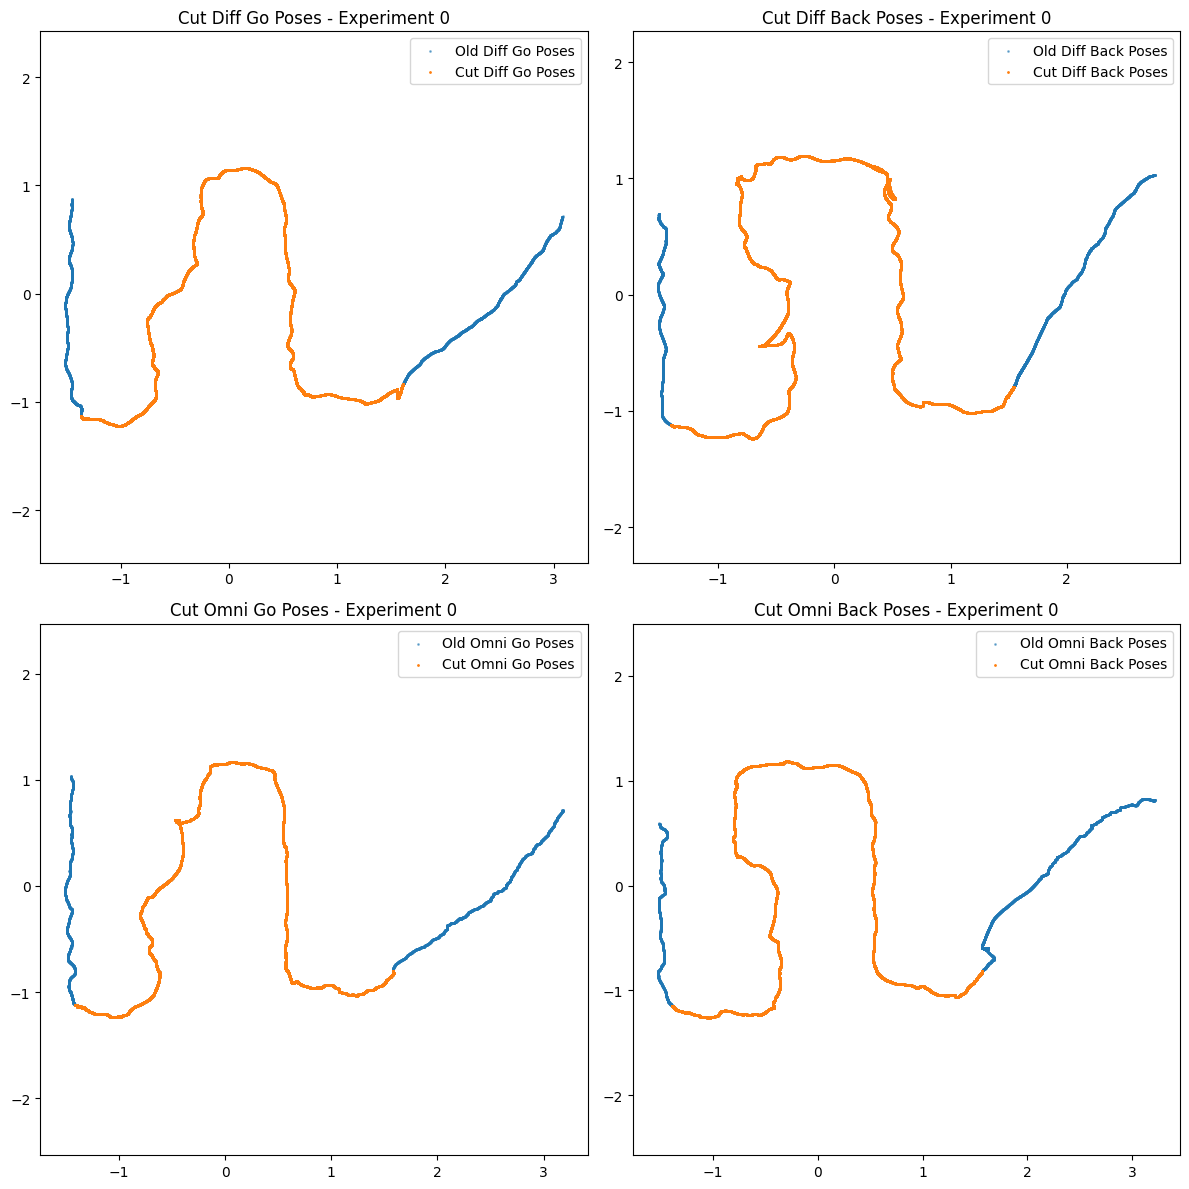

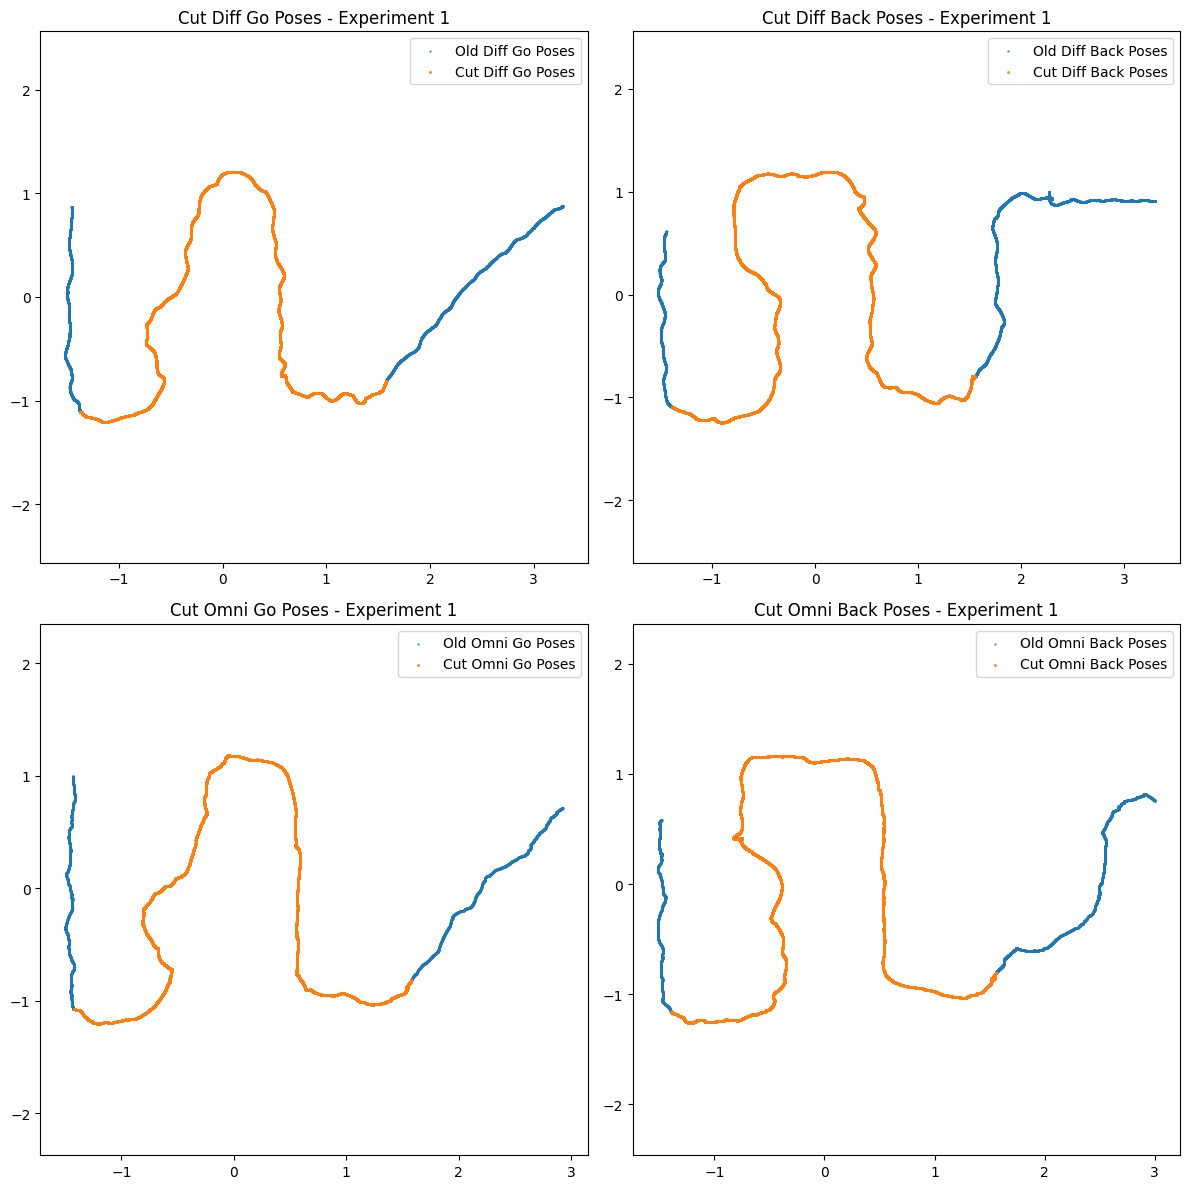

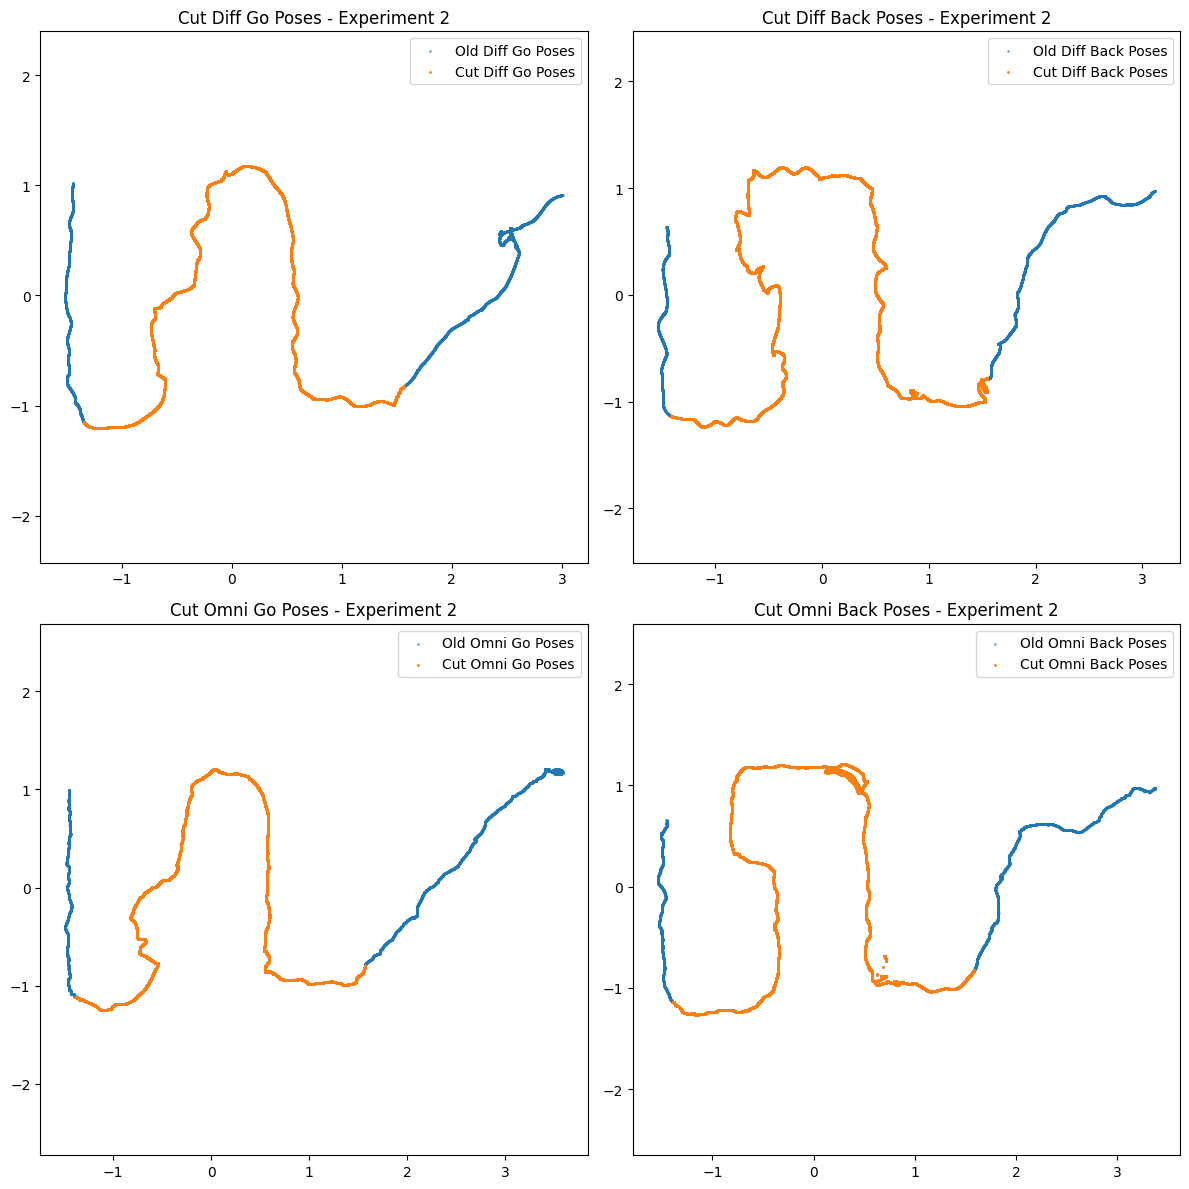

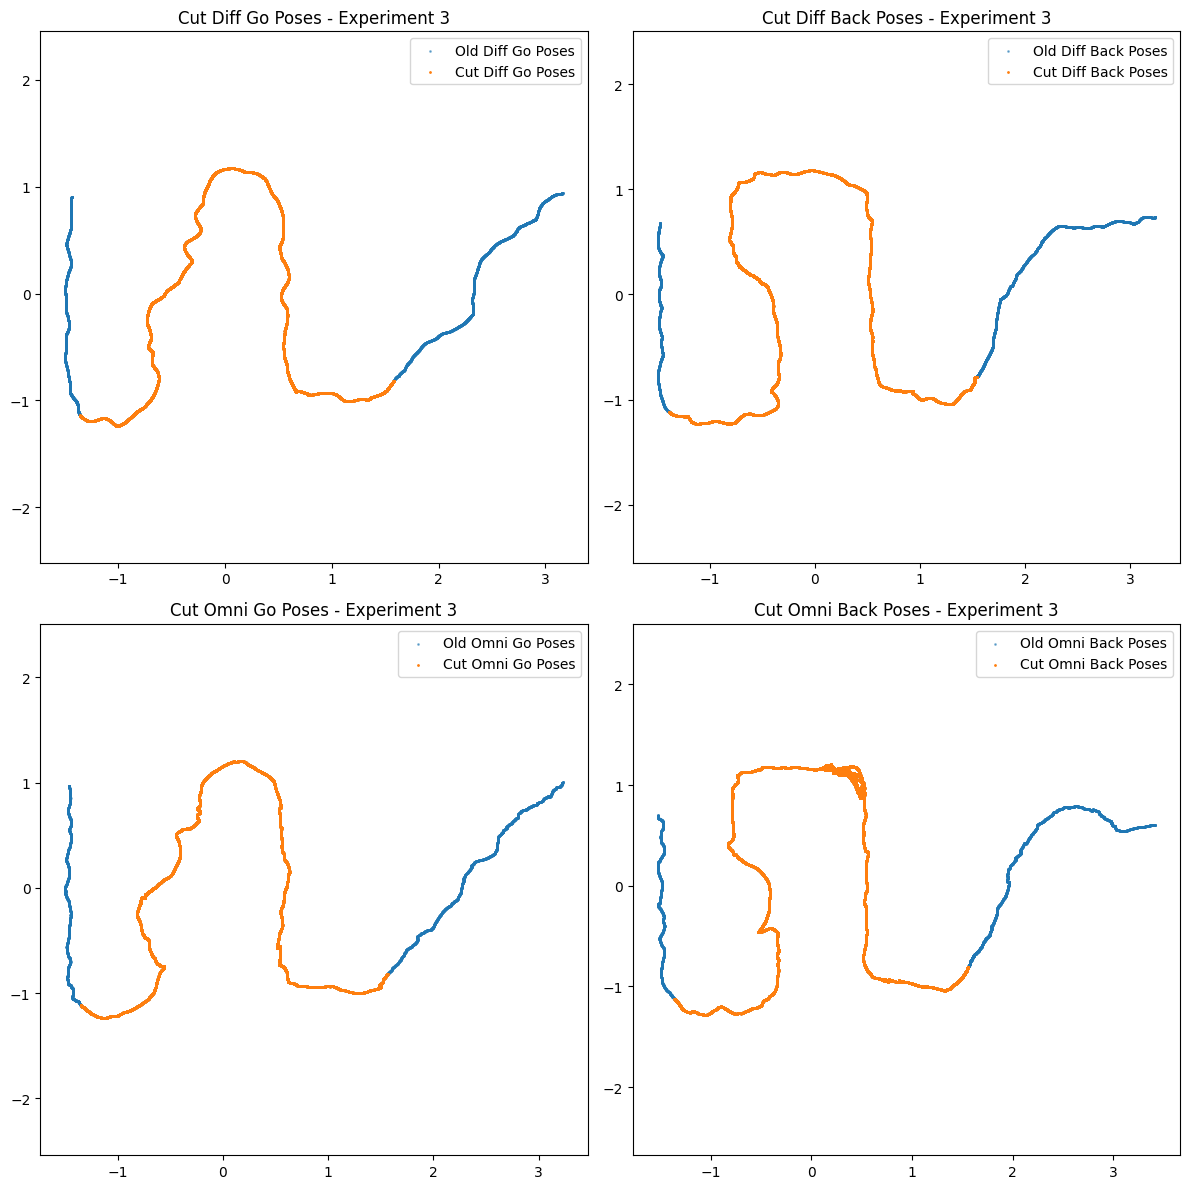

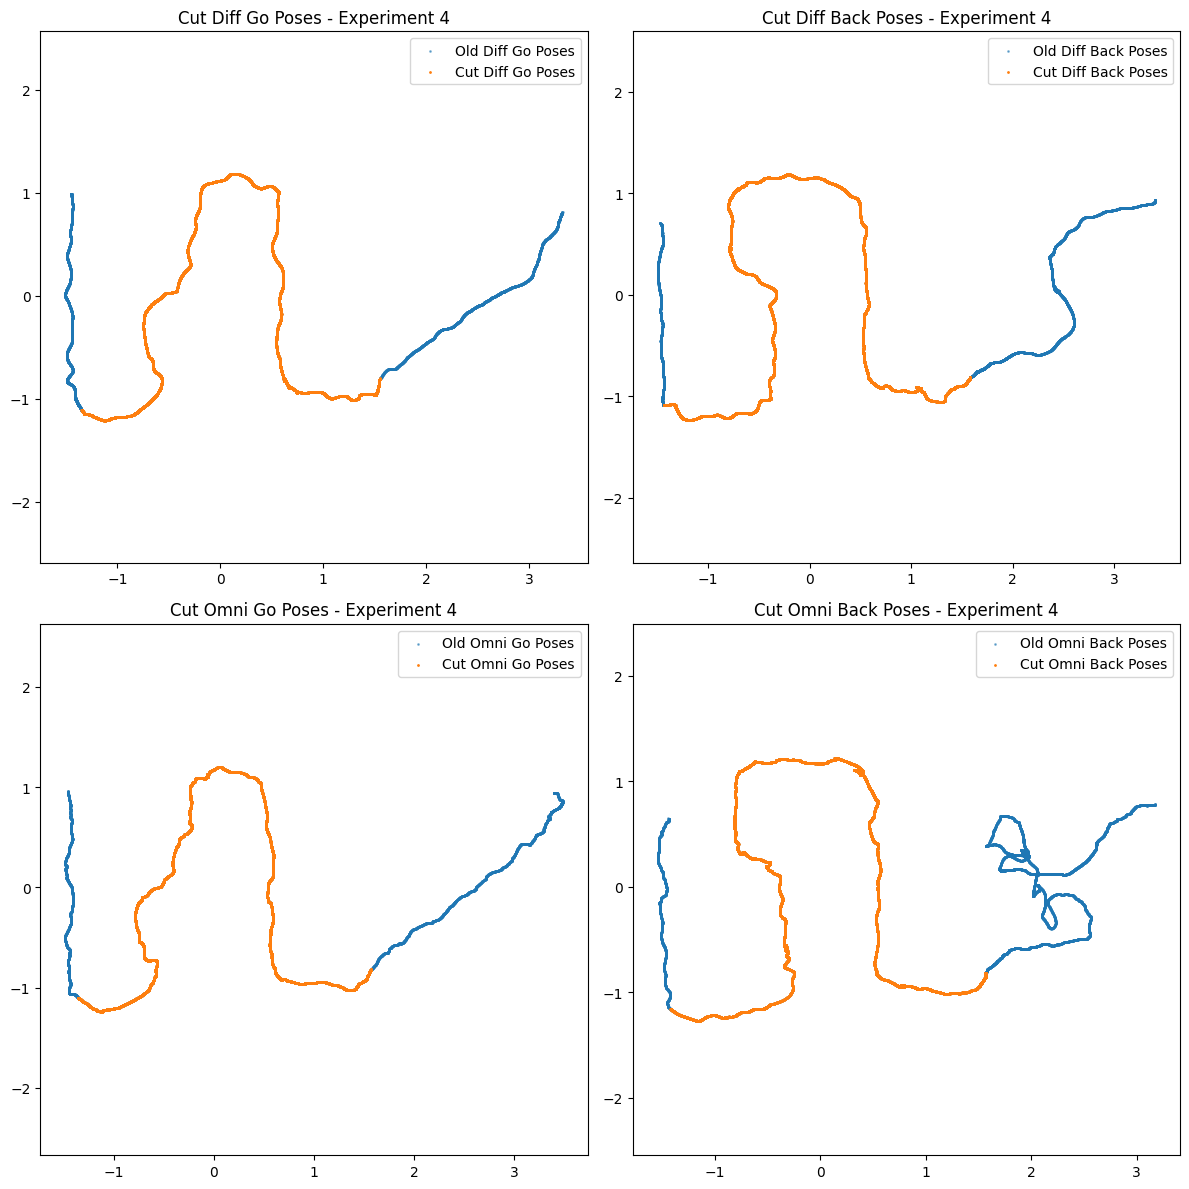

In [83]:
def find_closest_index(positions, cut_position):
    distances = np.linalg.norm(positions - cut_position, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

def cut_data_between_positions(poses, cut_position_1, cut_position_2):
    new_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in poses])
    start_index = find_closest_index(new_positions, cut_position_1)
    end_index = find_closest_index(new_positions, cut_position_2)
    return poses[start_index:end_index+1]

cut_new_diff_go_poses = {}
cut_new_diff_back_poses = {}
cut_new_omni_go_poses = {}
cut_new_omni_back_poses = {}

for i in range(len(new_diff_go_poses)):
    cut_new_diff_go_poses[i] = cut_data_between_positions(new_diff_go_poses[i], cut_position_1, cut_position_2)
    cut_new_diff_back_poses[i] = cut_data_between_positions(new_diff_back_poses[i], cut_position_2, cut_position_1)
    cut_new_omni_go_poses[i] = cut_data_between_positions(new_omni_go_poses[i], cut_position_1, cut_position_2)
    cut_new_omni_back_poses[i] = cut_data_between_positions(new_omni_back_poses[i], cut_position_2, cut_position_1)

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # Plot cut_new_diff_go_poses
    diff_go_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in cut_new_diff_go_poses[i]])
    old_diff_go_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_diff_go_poses[i]])
    axs[0, 0].scatter(old_diff_go_positions[:, 0], old_diff_go_positions[:, 1], s=1, alpha=0.5, label='Old Diff Go Poses')
    axs[0, 0].scatter(diff_go_positions[:, 0], diff_go_positions[:, 1], s=1, label='Cut Diff Go Poses')
    axs[0, 0].set_title(f'Cut Diff Go Poses - Experiment {i}')
    axs[0, 0].axis('equal')
    axs[0, 0].legend()
    
    # Plot cut_new_diff_back_poses
    diff_back_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in cut_new_diff_back_poses[i]])
    old_diff_back_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_diff_back_poses[i]])
    axs[0, 1].scatter(old_diff_back_positions[:, 0], old_diff_back_positions[:, 1], s=1, alpha=0.5, label='Old Diff Back Poses')
    axs[0, 1].scatter(diff_back_positions[:, 0], diff_back_positions[:, 1], s=1, label='Cut Diff Back Poses')
    axs[0, 1].set_title(f'Cut Diff Back Poses - Experiment {i}')
    axs[0, 1].axis('equal')
    axs[0, 1].legend()
    
    # Plot cut_new_omni_go_poses
    omni_go_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in cut_new_omni_go_poses[i]])
    old_omni_go_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_omni_go_poses[i]])
    axs[1, 0].scatter(old_omni_go_positions[:, 0], old_omni_go_positions[:, 1], s=1, alpha=0.5, label='Old Omni Go Poses')
    axs[1, 0].scatter(omni_go_positions[:, 0], omni_go_positions[:, 1], s=1, label='Cut Omni Go Poses')
    axs[1, 0].set_title(f'Cut Omni Go Poses - Experiment {i}')
    axs[1, 0].axis('equal')
    axs[1, 0].legend()
    
    # Plot cut_new_omni_back_poses
    omni_back_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in cut_new_omni_back_poses[i]])
    old_omni_back_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_omni_back_poses[i]])
    axs[1, 1].scatter(old_omni_back_positions[:, 0], old_omni_back_positions[:, 1], s=1, alpha=0.5, label='Old Omni Back Poses')
    axs[1, 1].scatter(omni_back_positions[:, 0], omni_back_positions[:, 1], s=1, label='Cut Omni Back Poses')
    axs[1, 1].set_title(f'Cut Omni Back Poses - Experiment {i}')
    axs[1, 1].axis('equal')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [103]:
cut_diff_go_times = []
cut_omni_go_times = []
cut_diff_back_times = []
cut_omni_back_times = []

for i in range(len(df)):
    cut_diff_go_times.append(round(elapsed_time_diff_go[i], 2))
    cut_omni_go_times.append(round(elapsed_time_omni_go[i], 2))
    cut_diff_back_times.append(round(elapsed_time_diff_back[i], 2))
    cut_omni_back_times.append(round(elapsed_time_omni_back[i], 2))

print('Cut Diff Go Times:')
print(cut_diff_go_times)
print('Cut Omni Go Times:')
print(cut_omni_go_times)
print('Cut Diff Back Times:')
print(cut_diff_back_times)
print('Cut Omni Back Times:')
print(cut_omni_back_times)

# min, max, mean, std

min_cut_diff_go = round(min(cut_diff_go_times), 2)
max_cut_diff_go = round(max(cut_diff_go_times), 2)
mean_cut_diff_go = round(np.mean(cut_diff_go_times), 2)
std_cut_diff_go = round(np.std(cut_diff_go_times), 2)

min_cut_omni_go = round(min(cut_omni_go_times), 2)
max_cut_omni_go = round(max(cut_omni_go_times), 2)
mean_cut_omni_go = round(np.mean(cut_omni_go_times), 2)
std_cut_omni_go = round(np.std(cut_omni_go_times), 2)

print(f"\nCut Diff Go Times - Min: {min_cut_diff_go}, Max: {max_cut_diff_go}, Mean: {mean_cut_diff_go}, Std: {std_cut_diff_go}")
print(f"Cut Omni Go Times - Min: {min_cut_omni_go}, Max: {max_cut_omni_go}, Mean: {mean_cut_omni_go}, Std: {std_cut_omni_go} \n")

min_cut_diff_back = round(min(cut_diff_back_times), 2)
max_cut_diff_back = round(max(cut_diff_back_times), 2)
mean_cut_diff_back = round(np.mean(cut_diff_back_times), 2)
std_cut_diff_back = round(np.std(cut_diff_back_times), 2)

min_cut_omni_back = round(min(cut_omni_back_times), 2)
max_cut_omni_back = round(max(cut_omni_back_times), 2)
mean_cut_omni_back = round(np.mean(cut_omni_back_times), 2)
std_cut_omni_back = round(np.std(cut_omni_back_times), 2)

print(f"Cut Diff Back Times - Min: {min_cut_diff_back}, Max: {max_cut_diff_back}, Mean: {mean_cut_diff_back}, Std: {std_cut_diff_back}")
print(f"Cut Omni Back Times - Min: {min_cut_omni_back}, Max: {max_cut_omni_back}, Mean: {mean_cut_omni_back}, Std: {std_cut_omni_back} \n")

mean_increase_diff_go_over_omni_go = round(mean_cut_diff_go - mean_cut_omni_go, 2)
mean_increase_diff_back_over_omni_back = round(mean_cut_diff_back - mean_cut_omni_back, 2)

percentage_increase_diff_go_over_omni_go = round((mean_increase_diff_go_over_omni_go / mean_cut_diff_go) * 100, 2)
percentage_increase_diff_back_over_omni_back = round((mean_increase_diff_back_over_omni_back / mean_cut_diff_back) * 100, 2)

print(f"Mean Increase Diff Go over Omni Go: {mean_increase_diff_go_over_omni_go}")
print(f"Mean Increase Diff Back over Omni Back: {mean_increase_diff_back_over_omni_back}")
print(f"Percentage Decrease Diff Go over Omni Go: {percentage_increase_diff_go_over_omni_go}%")
print(f"Percentage Decrease Diff Back over Omni Back: {percentage_increase_diff_back_over_omni_back}%")

Cut Diff Go Times:
[57.62, 55.77, 57.47, 59.23, 59.03]
Cut Omni Go Times:
[42.58, 40.83, 41.77, 52.35, 41.53]
Cut Diff Back Times:
[99.5, 70.38, 85.82, 90.2, 92.77]
Cut Omni Back Times:
[44.02, 47.2, 56.42, 80.28, 52.93]

Cut Diff Go Times - Min: 55.77, Max: 59.23, Mean: 57.82, Std: 1.25
Cut Omni Go Times - Min: 40.83, Max: 52.35, Mean: 43.81, Std: 4.31 

Cut Diff Back Times - Min: 70.38, Max: 99.5, Mean: 87.73, Std: 9.74
Cut Omni Back Times - Min: 44.02, Max: 80.28, Mean: 56.17, Std: 12.81 

Mean Increase Diff Go over Omni Go: 14.01
Mean Increase Diff Back over Omni Back: 31.56
Percentage Decrease Diff Go over Omni Go: 24.23%
Percentage Decrease Diff Back over Omni Back: 35.97%


In [93]:
import pandas as pd
def calculate_cumulative_distance(poses):
    cumulative_distance = 0
    for i in range(1, len(poses)):
        x1 = poses[i-1].pose.position.x
        y1 = poses[i-1].pose.position.y
        x2 = poses[i].pose.position.x
        y2 = poses[i].pose.position.y
        cumulative_distance += np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return cumulative_distance

dist_omni_go = []
dist_omni_back = []
dist_diff_go = []
dist_diff_back = []

for i in range(len(poses_omni_go)):
    dist_omni_go.append(calculate_cumulative_distance(new_omni_go_poses[i]))
    dist_omni_back.append(calculate_cumulative_distance(new_omni_back_poses[i]))

for i in range(len(poses_diff_go)):
    dist_diff_go.append(calculate_cumulative_distance(new_diff_go_poses[i]))
    dist_diff_back.append(calculate_cumulative_distance(new_diff_back_poses[i]))

# Create a DataFrame to display the distances
distance_data = {
    'Omni Go Distance': dist_omni_go,
    'Omni Back Distance': dist_omni_back,
    'Diff Go Distance': dist_diff_go,
    'Diff Back Distance': dist_diff_back
}

distance_df = pd.DataFrame(distance_data)
print(distance_df)

print('\n')

# min, max, mean, std

min_dist_omni_go = round(min(dist_omni_go), 2)
max_dist_omni_go = round(max(dist_omni_go), 2)
mean_dist_omni_go = round(np.mean(dist_omni_go), 2)
std_dist_omni_go = round(np.std(dist_omni_go), 2)

min_dist_omni_back = round(min(dist_omni_back), 2)
max_dist_omni_back = round(max(dist_omni_back), 2)
mean_dist_omni_back = round(np.mean(dist_omni_back), 2)
std_dist_omni_back = round(np.std(dist_omni_back), 2)

min_dist_diff_go = round(min(dist_diff_go), 2)
max_dist_diff_go = round(max(dist_diff_go), 2)
mean_dist_diff_go = round(np.mean(dist_diff_go), 2)
std_dist_diff_go = round(np.std(dist_diff_go), 2)

min_dist_diff_back = round(min(dist_diff_back), 2)
max_dist_diff_back = round(max(dist_diff_back), 2)
mean_dist_diff_back = round(np.mean(dist_diff_back), 2)
std_dist_diff_back = round(np.std(dist_diff_back), 2)

# Print the statistics in a table format
stats_data = {
    'Metric': ['Min', 'Max', 'Mean', 'Std'],
    'Diff Go': [min_dist_diff_go, max_dist_diff_go, mean_dist_diff_go, std_dist_diff_go],
    'Omni Go': [min_dist_omni_go, max_dist_omni_go, mean_dist_omni_go, std_dist_omni_go],
    'Diff Back': [min_dist_diff_back, max_dist_diff_back, mean_dist_diff_back, std_dist_diff_back],
    'Omni Back': [min_dist_omni_back, max_dist_omni_back, mean_dist_omni_back, std_dist_omni_back]   
}

stats_df = pd.DataFrame(stats_data)
print(stats_df.T)

   Omni Go Distance  Omni Back Distance  Diff Go Distance  Diff Back Distance
0         12.257384           13.196319         11.801170           14.419920
1         11.781358           12.831298         12.157186           14.034781
2         15.265994           16.417517         13.253356           14.845973
3         12.649420           16.479015         12.613200           13.696872
4         12.833935           18.373858         12.636178           14.469216


               0      1      2     3
Metric       Min    Max   Mean   Std
Diff Go     11.8  13.25  12.49  0.49
Omni Go    11.78  15.27  12.96  1.21
Diff Back   13.7  14.85  14.29  0.39
Omni Back  12.83  18.37  15.46  2.12


In [92]:
import pandas as pd
def calculate_cumulative_distance(poses):
    cumulative_distance = 0
    for i in range(1, len(poses)):
        x1 = poses[i-1].pose.position.x
        y1 = poses[i-1].pose.position.y
        x2 = poses[i].pose.position.x
        y2 = poses[i].pose.position.y
        cumulative_distance += np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return cumulative_distance

dist_omni_go = []
dist_omni_back = []
dist_diff_go = []
dist_diff_back = []

for i in range(len(poses_omni_go)):
    dist_omni_go.append(calculate_cumulative_distance(cut_new_omni_go_poses[i]))
    dist_omni_back.append(calculate_cumulative_distance(cut_new_omni_back_poses[i]))

for i in range(len(poses_diff_go)):
    dist_diff_go.append(calculate_cumulative_distance(cut_new_diff_go_poses[i]))
    dist_diff_back.append(calculate_cumulative_distance(cut_new_diff_back_poses[i]))

# Create a DataFrame to display the distances
distance_data = {
    'Omni Go Distance': dist_omni_go,
    'Omni Back Distance': dist_omni_back,
    'Diff Go Distance': dist_diff_go,
    'Diff Back Distance': dist_diff_back
}

distance_df = pd.DataFrame(distance_data)
print(distance_df)

print('\n')

# min, max, mean, std

min_dist_omni_go = round(min(dist_omni_go), 2)
max_dist_omni_go = round(max(dist_omni_go), 2)
mean_dist_omni_go = round(np.mean(dist_omni_go), 2)
std_dist_omni_go = round(np.std(dist_omni_go), 2)

min_dist_omni_back = round(min(dist_omni_back), 2)
max_dist_omni_back = round(max(dist_omni_back), 2)
mean_dist_omni_back = round(np.mean(dist_omni_back), 2)
std_dist_omni_back = round(np.std(dist_omni_back), 2)

min_dist_diff_go = round(min(dist_diff_go), 2)
max_dist_diff_go = round(max(dist_diff_go), 2)
mean_dist_diff_go = round(np.mean(dist_diff_go), 2)
std_dist_diff_go = round(np.std(dist_diff_go), 2)

min_dist_diff_back = round(min(dist_diff_back), 2)
max_dist_diff_back = round(max(dist_diff_back), 2)
mean_dist_diff_back = round(np.mean(dist_diff_back), 2)
std_dist_diff_back = round(np.std(dist_diff_back), 2)

# Print the statistics in a table format
stats_data = {
    'Metric': ['Min', 'Max', 'Mean', 'Std'],
    'Diff Go': [min_dist_diff_go, max_dist_diff_go, mean_dist_diff_go, std_dist_diff_go],
    'Omni Go': [min_dist_omni_go, max_dist_omni_go, mean_dist_omni_go, std_dist_omni_go],
    'Diff Back': [min_dist_diff_back, max_dist_diff_back, mean_dist_diff_back, std_dist_diff_back],
    'Omni Back': [min_dist_omni_back, max_dist_omni_back, mean_dist_omni_back, std_dist_omni_back]   
}

stats_df = pd.DataFrame(stats_data)
print(stats_df.T)

   Omni Go Distance  Omni Back Distance  Diff Go Distance  Diff Back Distance
0          7.538725            8.193867          7.387318           10.108711
1          7.368417            8.273858          7.465357            8.377177
2          7.602832           10.939598          7.388068           10.018089
3          7.616708           11.304016          7.762325            8.992166
4          7.488834            9.303798          7.676164            8.934109


              0      1     2     3
Metric      Min    Max  Mean   Std
Diff Go    7.39   7.76  7.54  0.15
Omni Go    7.37   7.62  7.52  0.09
Diff Back  8.38  10.11  9.29  0.67
Omni Back  8.19   11.3   9.6  1.31


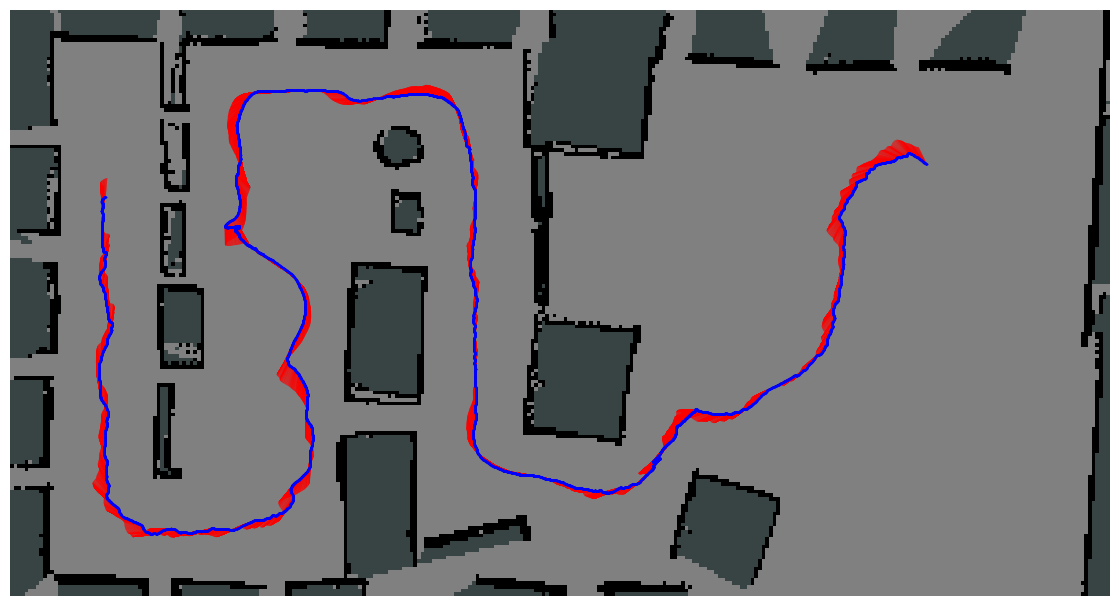

In [77]:
import numpy as np
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

# Map metadata
resolution = map_msg.info.resolution  # meters per cell
origin_x = map_msg.info.origin.position.x  # map origin x (in meters)
origin_y = map_msg.info.origin.position.y  # map origin y (in meters)
width = map_msg.info.width
height = map_msg.info.height

# Convert the map data to a NumPy array
map_data = np.array(map_msg.data).reshape((height, width))

# Create a custom color map: white for free space, black for obstacles, green for unknown
cmap = ListedColormap([color1_hex, '#000000', color2_hex]) 

# Replace values to correspond to the desired colors:
# - 0: free space (white), 100: obstacle (black), -1: unknown (green)
map_data_visual = np.copy(map_data)
map_data_visual[map_data == -1] = 2  # Set unknown cells to 2 (green)
map_data_visual[map_data == 0] = 0   # Set free space cells to 0 (white)
map_data_visual[map_data > 0] = 1    # Set occupied cells to 1 (black)

# Extract positions from new_omni_go_poses and poses_omni_go for path plotting
new_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_omni_back_poses[1]])
orientation = omni_back_yaw[1]

line_length = 0.1

# Set the figure size based on the aspect ratio
fig_width = 12  # You can adjust the width as desired
fig_height = fig_width / aspect_ratio

# Create the figure with the correct aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create the figure with correct scaling in meters
extent = [origin_x, origin_x + width * resolution, origin_y, origin_y + height * resolution]
ax.imshow(map_data_visual, cmap=cmap, origin='lower', extent=extent)

# Plot the paths on top of the map with smaller points
ax.scatter(new_positions[:, 0], new_positions[:, 1], label='New Omni Go Poses', s=0.2, color='blue', zorder=3)  # Decrease size to make thinner

# Plot the orientation lines with a thinner width
for (position, orientation) in zip(new_positions, orientation):
    x_start, y_start = position 
    x_end = x_start + line_length * np.cos(orientation)  
    y_end = y_start + line_length * np.sin(orientation) 

    # Plot the line for each robot position and orientation with thinner linewidth
    ax.plot([x_start, x_end], [y_start, y_end], color='red', zorder=2, linewidth=0.2)  # Thinner line

# Set your desired x and y limits
x_limits = [-2, 4]  # Set your desired x limits (start and end in meters)
y_limits = [-1.6, 1.6]
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

# Set labels and title
# ax.set_title('Occupancy Grid Map with Path Overlay')
# ax.set_xlabel('X (meters)')
# ax.set_ylabel('Y (meters)')
# ax.legend()
plt.tight_layout()
plt.axis('off')
# Save the figure as a PNG file with 300 dpi
fig.savefig('omni_path.png', dpi=300)
plt.show()

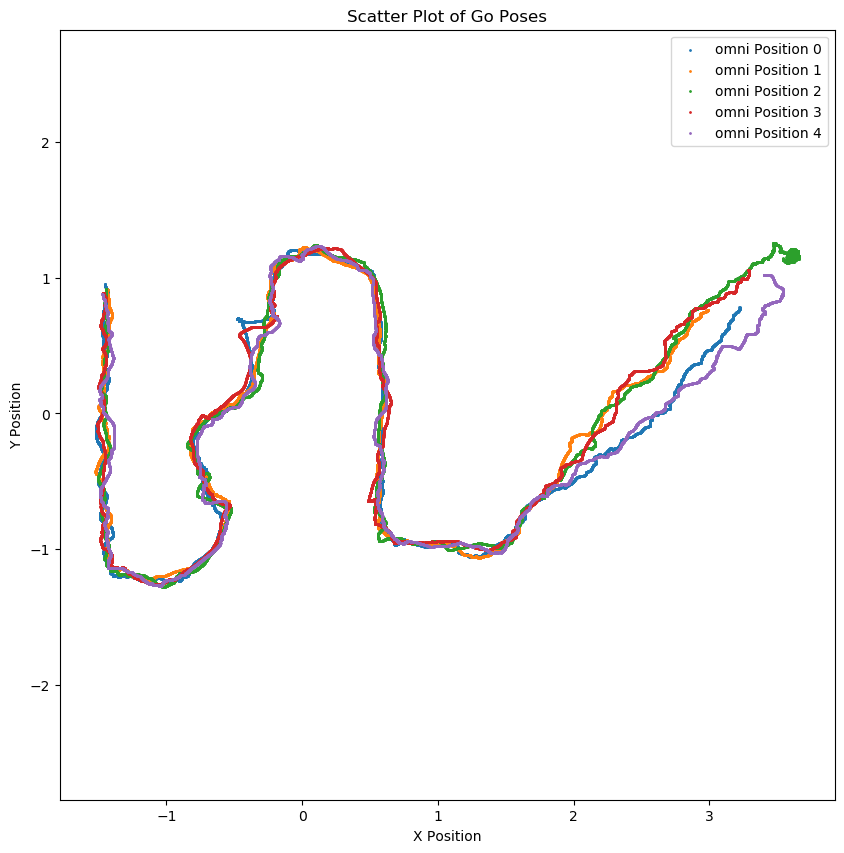

In [5]:
# 6.5cm
import matplotlib.pyplot as plt

# Scatter plot for positions_omni_go
plt.figure(figsize=(10, 10))

for i in poses_omni_go.keys():
    positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in poses_omni_go[i]])
    plt.scatter(positions[:, 0], positions[:, 1], label=f'omni Position {i}', s=1)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.title('Scatter Plot of Go Poses')
plt.legend()
plt.show()

In [5]:

def limit_data_frequency(data, times, max_frequency_hz):
    max_frequency_sec = 1 / max_frequency_hz

    new_data = []
    
    last_time = None
    for i, time in enumerate(times):
        if last_time is None:
            last_time = time
            new_data.append(data[i])
            continue

        dt = time - last_time

        if dt >= max_frequency_sec:
            new_data.append(data[i])
            last_time = time
    
    return new_data


# Limit the frequency of the data
max_frequency_hz = 10
poses_omni_go_filtered = {}
poses_omni_back_filtered = {}

for i in poses_omni_go.keys():
    pose_omni_go_times = [pose.header.stamp.to_sec() for pose in poses_omni_go[i]]
    poses_omni_go_filtered[i] = limit_data_frequency(poses_omni_go[i], pose_omni_go_times, max_frequency_hz)

    pose_omni_back_times = [pose.header.stamp.to_sec() for pose in poses_omni_back[i]]
    poses_omni_back_filtered[i] = limit_data_frequency(poses_omni_back[i], pose_omni_back_times, max_frequency_hz)

In [6]:
if not data_already_loaded:
    # Yaw values in radians
    # Orientations   
    orientations_omni_go_filtered = {}
    orientations_omni_back_filtered = {}
    for i in range(len(poses_omni_go)):
        orientations_omni_go_filtered[i] = []
        orientations_omni_back_filtered[i] = []
        for pose in poses_omni_go_filtered[i]:
            orientation_q = pose.pose.orientation
            orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
            roll, pitch, yaw = tf.transformations.euler_from_quaternion(orientation_list)
            orientations_omni_go_filtered[i].append(yaw)
        for pose in poses_omni_back_filtered[i]:
            orientation_q = pose.pose.orientation
            orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
            roll, pitch, yaw = tf.transformations.euler_from_quaternion(orientation_list)
            orientations_omni_back_filtered[i].append(yaw)
        
        orientations_omni_go_filtered[i] = np.array(orientations_omni_go_filtered[i])
        orientations_omni_back_filtered[i] = np.array(orientations_omni_back_filtered[i])

In [7]:
angular_velocity_omni_go = {}
angular_acceleration_omni_go = {}

angular_velocity_omni_back = {}
angular_acceleration_omni_back = {}

for i in orientations_omni_go_filtered.keys():
    # Calculate angular velocity (difference in yaw divided by time difference)
    angular_velocity_omni_go[i] = np.diff(orientations_omni_go_filtered[i]) / np.diff([pose.header.stamp.to_sec() for pose in poses_omni_go_filtered[i]])
    
    # Calculate angular acceleration (difference in angular velocity divided by time difference)
    angular_acceleration_omni_go[i] = np.diff(angular_velocity_omni_go[i]) / np.diff([pose.header.stamp.to_sec() for pose in poses_omni_go_filtered[i][1:]])

for i in orientations_omni_back_filtered.keys():
    # Calculate angular velocity (difference in yaw divided by time difference)
    angular_velocity_omni_back[i] = np.diff(orientations_omni_back_filtered[i]) / np.diff([pose.header.stamp.to_sec() for pose in poses_omni_back_filtered[i]])
    
    # Calculate angular acceleration (difference in angular velocity divided by time difference)
    angular_acceleration_omni_back[i] = np.diff(angular_velocity_omni_back[i]) / np.diff([pose.header.stamp.to_sec() for pose in poses_omni_back_filtered[i][1:]])

New sampling rate: 9.648937681347903
New sampling rate: 9.642847342105222
New sampling rate: 9.654233060750931
New sampling rate: 9.650255514826622
New sampling rate: 9.647290766072373


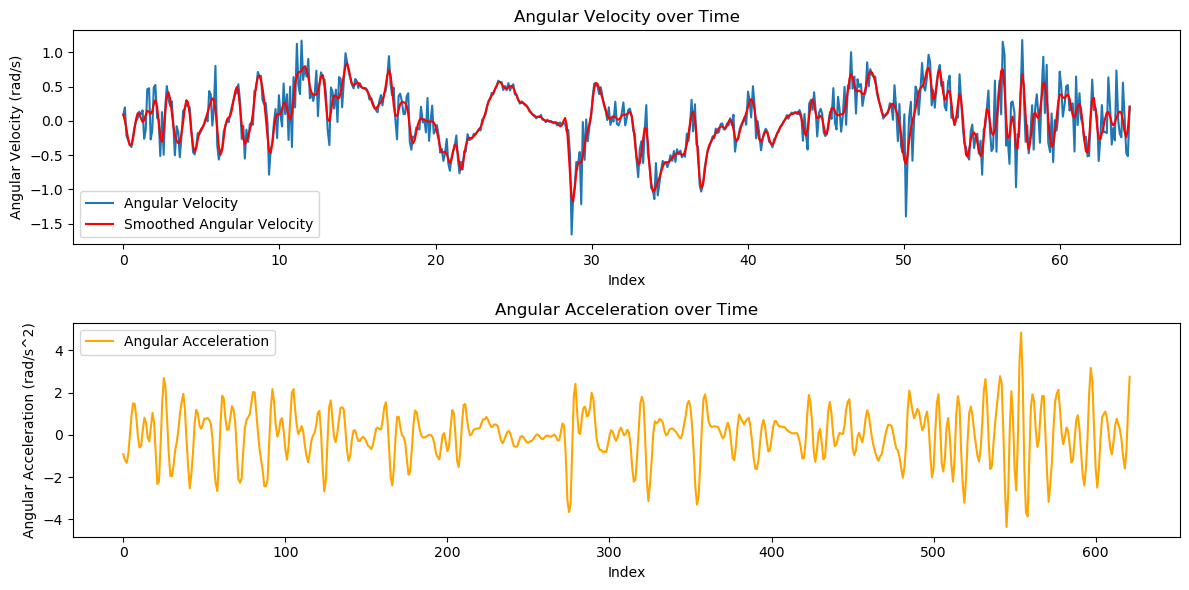

In [8]:
from scipy.signal import butter, filtfilt

def butterworth_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define thresholds
upper_threshold = 1000
lower_threshold = -1000

# Filter angular velocity
filtered_angular_velocity_omni = {}
smoothed_velocities = {}
elapsed_time = {}
smoothed_accelerations = {}
for i in angular_velocity_omni_go.keys():
    filtered_angular_velocity_omni[i] = np.clip(angular_velocity_omni_go[i], lower_threshold, upper_threshold)

    cutoff_frequency = 1.7
    new_sampling_rate = 1 / np.mean(np.diff([pose.header.stamp.to_sec() for pose in poses_omni_go_filtered[i]]))
    print(f"New sampling rate: {new_sampling_rate}")

    smoothed_velocities[i] = butterworth_filter(filtered_angular_velocity_omni[i], cutoff_frequency, new_sampling_rate)
    elapsed_time[i] = np.array([pose.header.stamp.to_sec() - poses_omni_go_filtered[i][0].header.stamp.to_sec() for pose in poses_omni_go_filtered[i]])
    elapsed_time[i] = elapsed_time[i][:-1]

    smoothed_accelerations[i] = np.diff(smoothed_velocities[i]) / np.diff(elapsed_time[i])

import matplotlib.pyplot as plt

# Plot angular velocity
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(elapsed_time[0], angular_velocity_omni_go[0], label='Angular Velocity')
plt.plot(elapsed_time[0], smoothed_velocities[0], label='Smoothed Angular Velocity', color='red')
plt.xlabel('Index')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity over Time')
plt.legend()

# Plot angular acceleration
plt.subplot(2, 1, 2)
plt.plot(smoothed_accelerations[0], label='Angular Acceleration', color='orange')
plt.xlabel('Index')
plt.ylabel('Angular Acceleration (rad/s^2)')
plt.title('Angular Acceleration over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
import numpy as np

def filter_lidar_scans(lidar_data, elapsed_time, accelerations, velocities, acceleration_threshold=0.4, velocity_threshold=0.15):
    # Calculate the elapsed time for each lidar scan
    lidar_elapsed_time = np.array([lidar.header.stamp.to_sec() - lidar_data[0].header.stamp.to_sec() for lidar in lidar_data])

    filtered_lidar_data = []

    # Iterate through lidar scans and their corresponding elapsed times
    for lidar, time in zip(lidar_data, lidar_elapsed_time):
        # Get the index of the acceleration/velocity value closest to the time of the lidar scan
        index = np.argmin(np.abs(elapsed_time - time))

        # Retrieve the corresponding acceleration and velocity values
        acceleration_value = accelerations[index - 1]
        velocity_value = velocities[index - 1]

        # Apply filtering conditions based on acceleration and velocity thresholds
        if (np.abs(acceleration_value) < acceleration_threshold) and (np.abs(velocity_value) < velocity_threshold):
            filtered_lidar_data.append(lidar)

    return filtered_lidar_data


In [10]:
acceleration_threshold = 0.3
velocity_threshold = 0.4

lidar_omni_go_filtered = {}
for i in range(len(lidar_omni_go)):
    lidar_omni_go_filtered[i] = filter_lidar_scans(lidar_omni_go[i], elapsed_time[i], smoothed_accelerations[i], smoothed_velocities[i], acceleration_threshold, velocity_threshold)

print(len(lidar_omni_go[0]), len(lidar_omni_go_filtered[0]))
print(len(lidar_omni_go[1]), len(lidar_omni_go_filtered[1]))
print(len(lidar_omni_go[2]), len(lidar_omni_go_filtered[2]))
print(len(lidar_omni_go[3]), len(lidar_omni_go_filtered[3]))
print(len(lidar_omni_go[4]), len(lidar_omni_go_filtered[4]))

840 167
803 159
980 130
1010 285
883 115


In [11]:
import copy
import laser_geometry
import tf2_ros
import tf2_sensor_msgs

def transform_laser_scans_to_world_frame(filtered_lidar_scans, tf_buffer, target_frame='world', max_range=6.0):
    """
    Transforms a list of LaserScan messages to the specified world frame and returns the transformed PointCloud2 data.

    Args:
        filtered_lidar_scans (list): List of LaserScan messages to be transformed.
        tf_buffer (tf2_ros.Buffer): TF buffer to lookup transforms.
        target_frame (str): The target frame to transform the data to. Default is 'world'.
        max_range (float): The maximum range to filter LaserScan points. Points greater than max_range will be set to infinity.

    Returns:
        list: List of transformed PointCloud2 messages in the target frame.
    """
    # Create a laser projector object to convert LaserScan to PointCloud2
    projector = laser_geometry.LaserProjection()
    lidar_world_frame = []

    # Iterate over each LaserScan message
    for original_msg in filtered_lidar_scans:
        try:
            # Create a deep copy of the original LaserScan message to avoid modifying it
            msg = copy.deepcopy(original_msg)
            
            # Get the transform from the source frame to the target frame at the message timestamp
            transform = tf_buffer.lookup_transform(target_frame, msg.header.frame_id, msg.header.stamp)

            # Filter out scan messages with ranges greater than max_range (work on the copied data)
            msg.ranges = [r if r <= max_range else float('inf') for r in msg.ranges]

            # Convert LaserScan to PointCloud2 using the laser geometry projector
            cloud = projector.projectLaser(msg)

            # Transform the PointCloud2 to the target frame
            transformed_cloud = tf2_sensor_msgs.do_transform_cloud(cloud, transform)

            # Append the transformed PointCloud2 to the list
            lidar_world_frame.append(transformed_cloud)

            

        except tf2_ros.LookupException as e:
            print(f"LookupException: {e}")
        except tf2_ros.ExtrapolationException as e:
            print(f"ExtrapolationException: {e}")
        except Exception as e:
            print(f"Transformation failed at time {msg.header.stamp.to_sec()}: {e}")

    return np.array(lidar_world_frame)

In [12]:
import copy
import tf2_ros
import tf2_geometry_msgs
import numpy as np
from sensor_msgs.msg import PointCloud
from geometry_msgs.msg import Point32

def transform_pointcloud_to_world_frame(filtered_pointclouds, tf_buffer, target_frame='world'):
    """
    Transforms a list of PointCloud messages to the specified world frame and returns the transformed data as a NumPy array.

    Args:
        filtered_pointclouds (list): List of PointCloud messages to be transformed.
        tf_buffer (tf2_ros.Buffer): TF buffer to lookup transforms.
        target_frame (str): The target frame to transform the data to. Default is 'world'.

    Returns:
        np.ndarray: Array of transformed points (x, y, z) for each PointCloud in the target frame.
    """
    pointcloud_world_frame = []

    for original_msg in filtered_pointclouds:
        try:
            # Create a deep copy of the original PointCloud message to avoid modifying it
            msg = copy.deepcopy(original_msg)
            
            # Get the transform from the source frame to the target frame at the message timestamp
            transform = tf_buffer.lookup_transform(target_frame, msg.header.frame_id, msg.header.stamp)

            # Transform each Point32 in the PointCloud
            transformed_points = []
            for point in msg.points:
                # Create a geometry_msgs PointStamped from Point32 for transformation
                point_stamped = tf2_geometry_msgs.PointStamped()
                point_stamped.header = msg.header
                point_stamped.point.x = point.x
                point_stamped.point.y = point.y
                point_stamped.point.z = point.z

                # Apply the transformation
                transformed_point = tf2_geometry_msgs.do_transform_point(point_stamped, transform)

                # Append the transformed point as a tuple (x, y, z)
                transformed_points.append((transformed_point.point.x,
                                           transformed_point.point.y,
                                           transformed_point.point.z))

            # Convert the list of points into a NumPy array
            pointcloud_array = np.array(transformed_points, dtype=np.float32)

            # Append the array to the list
            pointcloud_world_frame.append(pointcloud_array)

        except tf2_ros.LookupException as e:
            print(f"LookupException: {e}")
        except tf2_ros.ExtrapolationException as e:
            print(f"ExtrapolationException: {e}")
        except Exception as e:
            print(f"Transformation failed at time {msg.header.stamp.to_sec()}: {e}")

    return np.array(pointcloud_world_frame)

In [13]:
laser_omni_go_filtered_world = {}

for i in range(len(lidar_omni_go_filtered)):
    laser_omni_go_filtered_world[i] = transform_laser_scans_to_world_frame(lidar_omni_go_filtered[i], tf_buffer)


In [13]:
import sensor_msgs.point_cloud2 as pc2

# Save lidar data to file
lidar_omni_go_save = {}

for i in range(len(lidar_omni_go)):
    lidar_omni_go_save [i] = transform_laser_scans_to_world_frame(lidar_omni_go_filtered[i], tf_buffer)

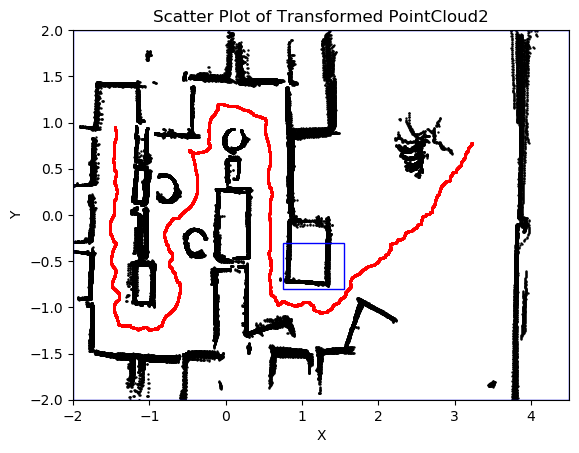

In [14]:
import sensor_msgs.point_cloud2 as pc2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

wich_experiment = 1

lidar_points = []

for transformed_cloud in laser_omni_go_filtered_world[wich_experiment - 1]:
    # Read the points from the PointCloud2 message
    points = list(pc2.read_points(transformed_cloud, field_names=("x", "y", "z"), skip_nans=True))

    # Filter points with x values greater than 2
    # Filter points with x values between -2 and 2 and y values between -2 and 2
    points = [point for point in points if -2 <= point[0] <= 4.5 and -2 <= point[1] <= 2]

    # Convert to numpy array for easier manipulation
    points_array = np.array(points)

    lidar_points.extend(points_array)

# Scatter plot the points
lidar_points = np.array(lidar_points)

plt.scatter(lidar_points[:, 0], lidar_points[:, 1], c='black', s=0.5)

positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in poses_omni_go[wich_experiment - 1]])
plt.scatter(positions[:, 0], positions[:, 1], label=f'omni Position {i}', s=1, c='red')

# Draw a rectangle
rect = plt.Rectangle((-2, -2), 6.5, 4, linewidth=1, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)

rect = plt.Rectangle((0.75, -0.8), 0.8, 0.5, linewidth=1, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)

plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-2, 2)
plt.xlim(-2, 4.5)
plt.title('Scatter Plot of Transformed PointCloud2')
# plt.axis('equal')
plt.show()

In [55]:
# import copy
# import tf2_ros
# import tf2_geometry_msgs
# from sensor_msgs.msg import PointCloud2, PointCloud

# import sensor_msgs.point_cloud2 as pc2

# def transform_base_points_to_world(base_points, tf_buffer, target_frame='world'):
#     transformed_base_points = []

#     for point_cloud in base_points:
#         try:
#             # Get the transform from the source frame to the target frame at the message timestamp
#             transform = tf_buffer.lookup_transform(target_frame, point_cloud.header.frame_id, point_cloud.header.stamp)

#             # Transform the PointCloud to the target frame
#             transformed_cloud = tf2_sensor_msgs.do_transform_cloud(point_cloud, transform)

#             # Append the transformed PointCloud to the list
#             transformed_base_points.append(transformed_cloud)

#         except tf2_ros.LookupException as e:
#             print(f"LookupException: {e}")
#         except tf2_ros.ExtrapolationException as e:
#             print(f"ExtrapolationException: {e}")
#         except Exception as e:
#             print(f"Transformation failed at time {point_cloud.header.stamp.to_sec()}: {e}")

#     return transformed_base_points

# # Transform base points for omni go
# transformed_base_points_omni_go = {}
# for i in range(len(base_points_omni_go)):
#     transformed_base_points_omni_go[i] = transform_base_points_to_world(base_points_omni_go[i], tf_buffer)

# # Transform base points for omni back
# transformed_base_points_omni_back = {}
# for i in range(len(base_points_omni_back)):
#     transformed_base_points_omni_back[i] = transform_base_points_to_world(base_points_omni_back[i], tf_buffer)

Transformation failed at time 1726707779.3883862: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707779.462569: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707779.5421119: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707779.6145709: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707779.6963577: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707779.7703958: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707779.8482902: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707779.9219239: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707780.0036516: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707780.0785348: cloud is not a sensor_msgs.msg.PointCloud2
Transformation failed at time 1726707780.1561692: cloud is not a sensor

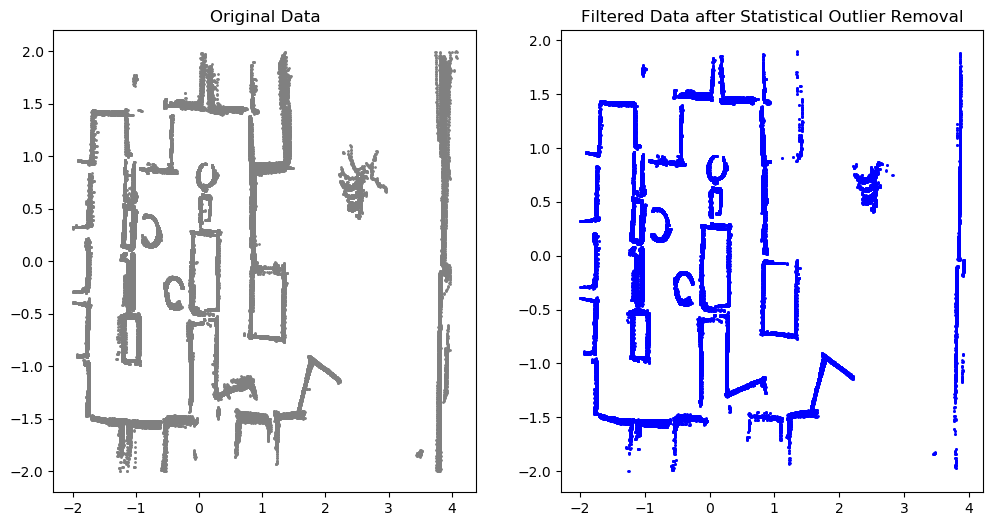

In [33]:

# Convert to Open3D PointCloud
# points_3d = np.hstack((lidar_points, np.zeros((lidar_points.shape[0], 1))))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(lidar_points)

# Apply Statistical Outlier Removal
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=2, std_ratio=1) 
# nb_neighbors is the number of neighbors to analyze for each point, std_ratio is the standard deviation ratio 
filtered_pcd = pcd.select_by_index(ind)
filtered_data = np.asarray(filtered_pcd.points)[:, :2]

# Visualize
plt.figure(figsize=(12, 6))

# Original lidar_points
plt.subplot(1, 2, 1)
plt.scatter(lidar_points[:, 0], lidar_points[:, 1], s=1, color='gray')
plt.title('Original Data')

# Filtered Data
plt.subplot(1, 2, 2)
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=1, color='blue')
plt.title('Filtered Data after Statistical Outlier Removal')

plt.show()

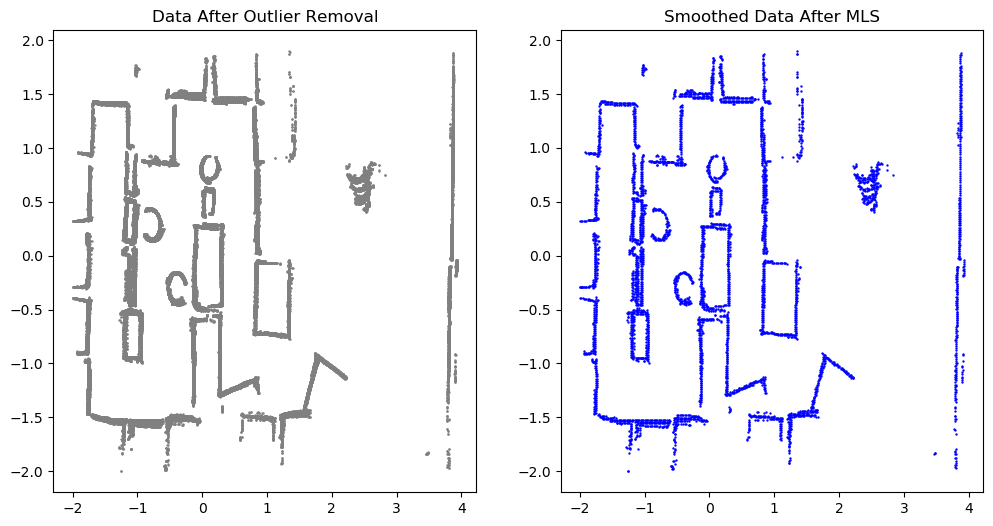

In [47]:
import numpy as np
import open3d as o3d

# Assuming 'filtered_data' is your numpy array after outlier removal with shape (N, 2)
# Convert to Open3D PointCloud with z = 0
points_3d = np.hstack((filtered_data, np.zeros((filtered_data.shape[0], 1))))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)

# Apply voxel downsampling for smoothing
voxel_size = 0.02  # Adjust voxel size based on your data scale
smoothed_pcd = pcd.voxel_down_sample(voxel_size=voxel_size)

# Estimate normals for the smoothed point cloud
smoothed_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=30))
# # Apply MLS smoothing
# voxel_size = 0.02  # Adjust voxel size based on your data scale
# smoothed_pcd = pcd.voxel_down_sample(voxel_size=voxel_size)

# Convert back to 2D numpy array (discard z-coordinate)
smoothed_data = np.asarray(smoothed_pcd.points)[:, :2]

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=0.5, color='gray')
plt.title('Data After Outlier Removal')

plt.subplot(1, 2, 2)
plt.scatter(smoothed_data[:, 0], smoothed_data[:, 1], s=0.5, color='blue')
plt.title('Smoothed Data After MLS')

plt.show()

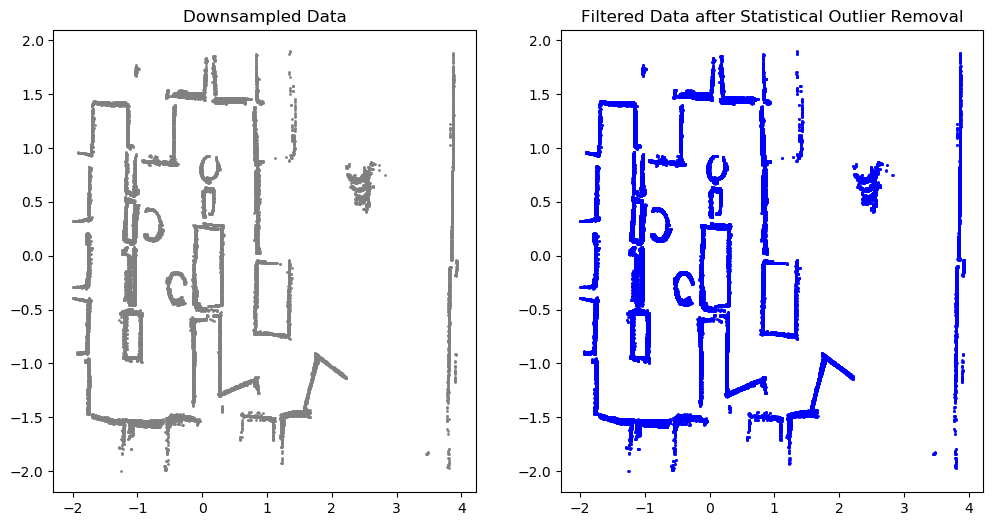

In [40]:
downsampled_pcd = pcd.voxel_down_sample(voxel_size=0.01)

# Visualize downsampled point cloud
downsampled_points = np.asarray(downsampled_pcd.points)

plt.figure(figsize=(12, 6))

# Downsampled lidar_points
plt.subplot(1, 2, 1)
plt.scatter(downsampled_points[:, 0], downsampled_points[:, 1], s=1, color='gray')
plt.title('Downsampled Data')

# Filtered Data
plt.subplot(1, 2, 2)
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=1, color='blue')
plt.title('Filtered Data after Statistical Outlier Removal')

plt.show()

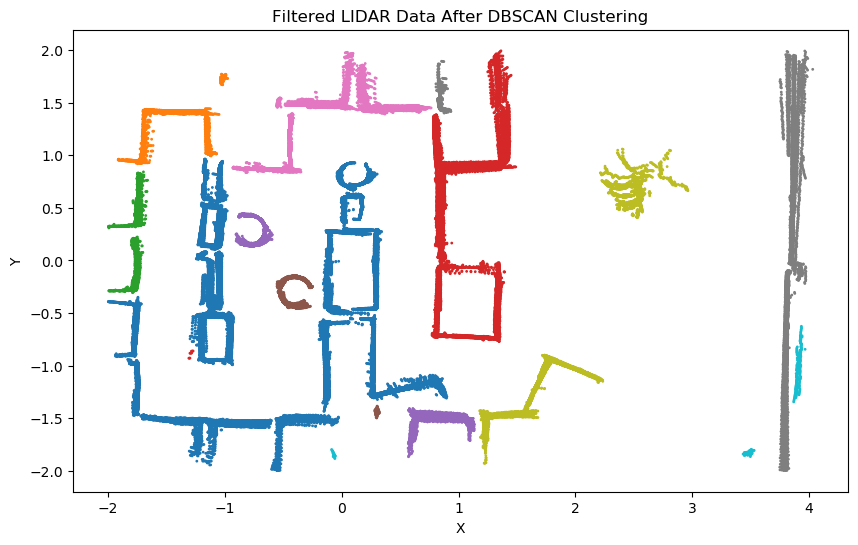

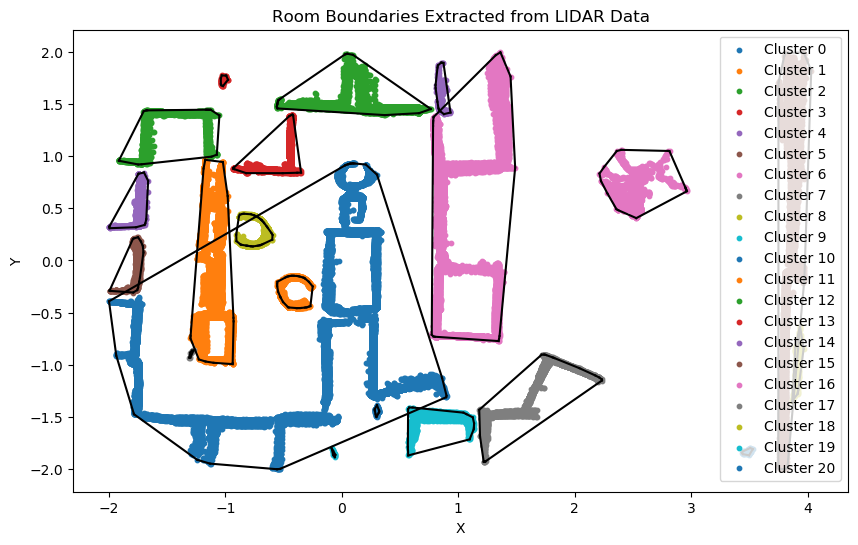

In [16]:

# lidar_points = np.array(lidar_points)
# # Remove the z component, as we are working in 2D
# points_2d = lidar_points[:, :2]

# # Step 2: Apply DBSCAN to cluster points
# dbscan = DBSCAN(eps=0.05, min_samples=10)  # Adjust eps and min_samples based on your data distribution
# labels = dbscan.fit_predict(points_2d)

# # Remove noise points (points labeled as -1)
# filtered_points = points_2d[labels != -1]
# filtered_labels = labels[labels != -1]

# # Step 3: Plot the filtered clusters
# plt.figure(figsize=(10, 6))
# plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c=filtered_labels, cmap='tab10', s=1)
# plt.title("Filtered LIDAR Data After DBSCAN Clustering")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.show()

# # Step 4: Extract boundaries using ConvexHull for each cluster
# unique_labels = set(filtered_labels)
# plt.figure(figsize=(10, 6))

# for label in unique_labels:
#     cluster_points = filtered_points[filtered_labels == label]
    
#     # Extract boundary using ConvexHull
#     if len(cluster_points) >= 3:  # ConvexHull requires at least 3 points
#         hull = ConvexHull(cluster_points)
        
#         # Plot the ConvexHull boundary
#         for simplex in hull.simplices:
#             plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-')

#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {label}')

# plt.title("Room Boundaries Extracted from LIDAR Data")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend()
# plt.show()